# RL-controlled adaptive time stepping (user-defined)

This notebook mixes hand-tuned and reinforcement-learning controllers built

around `Solve_IVP_NS`. Reward shaping, observations, and agent choices live

in the notebook so you can modify them freely; they are **not** part of the

package API. Treat the RL portions as optional user code rather than required

steps when installing or testing the solver library.


In [29]:
from plants.faults import strikeslip
import os

import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import time



In [30]:
import autograd.numpy as anp
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
th.set_default_dtype(th.float32)

In [76]:
from pathlib import Path
DATA_DIR = str((Path.cwd() / "Data").resolve())
print(f"Loading: {DATA_DIR}/kijs_2x2elem-3x3length.npy")

# Initialize fault model
fault = strikeslip.qs_strikeslip_fault(
    zdepth=3, xlength=3, Nz=50, Nx=50,  
    G=30000., rho=2.5e-3, zeta=0.8/3, 
    Ks_path="./Data/", gamma_s=25., gamma_w=10., 
    sigma_ref=100., depth_ini=0., vinf=3.171e-10, 
    Dmu_estimate=.5,
)

# Get plant parameters
MA, KS, ES, SIGMA_N, VINF_raw = fault.get_plant()

# Print diagnostic information
print(f"Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: {KS.sum()}")
print(f"Approximate value of total stiffness assuming a patch of length Lx: {3.333333333333333e-07}")
print(f"Calculated value: {3.962559156372552e-07}")
print(f"Units are in: mm,N,ms,MPa,gr")

Loading: /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/Data/kijs_2x2elem-3x3length.npy
Loading: ./Data/kijs_50x50elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  1.0146563948025665e-06
Units are in: mm,N,ms,MPa,gr
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: 3572.902392706202
Approximate value of total stiffness assuming a patch of length Lx: 3.333333333333333e-07
Calculated value: 3.962559156372552e-07
Units are in: mm,N,ms,MPa,gr


In [77]:
import scipy.sparse as sp

N_DOFS = fault.N                                # int
VINF = VINF_raw * np.ones(N_DOFS)*0               # scalar vinf

# Sparse block matrix for the solver (CSR)
# A = block_diag([MA, I, I]) with zeros off the block-diagonals
I_N = sp.eye(N_DOFS, format='csr')
A = sp.block_diag([sp.csr_matrix(MA), I_N, I_N], format='csr')

# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]

print(f')

In [78]:
import math
from numba import njit

KS_dense = np.ascontiguousarray(KS, dtype=np.float64)
ES_dense = np.ascontiguousarray(ES, dtype=np.float64)
VINF_vec = np.ascontiguousarray(VINF, dtype=np.float64)

_rhs_buffer = np.empty(3 * N_DOFS, dtype=np.float64)
_rhs_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _rhs_kernel(y, KS, ES, VINF, out):
    n = VINF.shape[0]
    for i in range(n):
        sum_ku = 0.0
        sum_ev = 0.0
        yi = y[i]
        for j in range(n):
            sum_ku += KS[i, j] * y[n + j]
            sum_ev += ES[i, j] * (y[j] - VINF[j])
        out[i] = -(sum_ku + sum_ev)
        out[n + i] = yi - VINF[i]
        out[2 * n + i] = yi if yi >= 0.0 else -yi

def rhs(t, y):
    _rhs_kernel(y, KS_dense, ES_dense, VINF_vec, _rhs_buffer)
    return _rhs_buffer.copy()

def rhs_jac(t, y, Fk_val=None):
    n = N_DOFS
    jac = _rhs_jac_buffer
    jac.fill(0.0)
    jac[:n, :n] = -ES_dense
    jac[:n, n:2 * n] = -KS_dense
    rows_primary = n + np.arange(n)
    jac[rows_primary, np.arange(n)] = 1.0
    slip_signs = np.sign(y[:n]).astype(np.float64)
    jac[2 * n + np.arange(n), np.arange(n)] = slip_signs
    return jac.copy()

In [79]:
DMU = -0.1   # Friction drop amount (adjust based on your problem)
DC = 100.0 / fault.Dscale    # Characteristic slip distance (adjust based on your problem)
MU_RES = 0.5

SIGMA_N_vec = np.ascontiguousarray(SIGMA_N, dtype=np.float64)

_con_force_buffer = np.zeros(3 * N_DOFS, dtype=np.float64)
_con_force_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _con_force_kernel(state, sigma_n, mu_res, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        mu_val = mu_res * (1.0 - (dmu / mu_res) * math.exp(-slip_i / dc))
        out[i] = mu_val * sigma_n[i]

@njit(cache=True)
def _con_force_jac_kernel(state, sigma_n, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        dmu_dslip = (dmu / dc) * math.exp(-slip_i / dc)
        out[i, 2 * n + i] = sigma_n[i] * dmu_dslip

def con_force(state, fk=None):
    _con_force_buffer.fill(0.0)
    _con_force_kernel(state, SIGMA_N_vec, MU_RES, DMU, DC, _con_force_buffer)
    return _con_force_buffer.copy()


def con_force_jacobian(state, t=None, Fk_val=None):
    _con_force_jac_buffer.fill(0.0)
    _con_force_jac_kernel(state, SIGMA_N_vec, DMU, DC, _con_force_jac_buffer)
    return _con_force_jac_buffer.copy()


In [80]:
# projection and solver options
projection_opts = {
    'con_force_func': con_force,
    'rhok': np.ones(N_DOFS, dtype=float),
    'component_slices': component_slices,
    'constraint_indices': np.arange(N_DOFS, dtype=np.int32),
    # 'jac_func': con_force_jacobian,  # analytical Jacobian for CoulombProjection

}

# Tuned nonlinear-solver options shared by VI and SSN
solver_opts_common = dict(
    tol=1e-6,
    max_iter=100,
    rhs_jac=rhs_jac,      # enables exact residual Jacobian in integrators
    # linear_solver='dense',
    # use_broyden=True,
    # adaptive_lam = False
 )

# Adaptive controller tuned for nonsmooth dynamics
adaptive_opts = dict(
    h0=5e-2,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,           # conservative order for nonsmooth dynamics
    skip_error_indices=[],
    controller='h211b',              # smoother steps with PI control
    b_param=4.0,         # only if controller == "H211b"
    mode = 'classic'

 )

# SSN-specific tweaks for robustness and speed
solver_opts_ssn = dict(solver_opts_common)
solver_opts_ssn.update({
    "vi_strict_block_lipschitz": False,   # was True by default
    "vi_max_block_adjust_iters": 10,       # smaller safety cap
    "globalization": 'line_search',    # more robust globalization
})


In [81]:
y0 = np.zeros(3 * N_DOFS)
friction_force = con_force(y0)
uc = -np.linalg.solve(KS,friction_force[:N_DOFS]) #displacement at frictional instability

u0 = uc * (1 + 1e-5) # peturb uc displacement slighty

y0[ N_DOFS : 2 * N_DOFS] = u0
Uint =  0.5 * np.dot(u0, KS @ u0) #initial internal energy
Uintc =  0.5 * np.dot(uc, KS @ uc) # internal energy at frictional instability used to normalize energy


# print(f"Initial slip values (s0): {u0}")
# print(f"Initial state (y0): {y0}")

In [82]:
# === Full semismooth Newton solves: pure Python vs Numba, plus BDF reference ===
# We run the full integrator twice, once forcing pure Python (use_numba=False)
# and once forcing Numba acceleration (use_numba=True). Then we also solve
# the regularized smooth problem with SciPy's BDF for comparison.
tmax=  30 * fault.second / fault.Tscale


t_span = (0.0, tmax)
# # Make a copy of base solver opts for semismooth Newton
# solver_opts_ssn = solver_opts.copy()
# solver_opts_ssn['max_iter'] = 100


projection_opts_nb = dict(projection_opts)
projection_opts_nb['use_numba'] = True   # force Numba path



# --- Semismooth Newton (Numba) ---
start_nb = time.time()
(t_vals_ssn_nb,
 y_vals_ssn_nb,
 h_vals_ssn_nb,
 fk_vals_ssn_nb,
 solver_info_ssn_nb,
 attempt_log_ssn) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='VI',
    projection_opts=projection_opts_nb,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    return_attempts=True,
    adaptive_opts=adaptive_opts,
    # atol=1e-8,
    # rtol=1e-6,
    h0=30/4 * fault.second / fault.Tscale,
    component_slices=component_slices,
    verbose=True,
    A=A
)
rt_nb = time.time() - start_nb
print(f"Semismooth (Numba)  solve complete in {rt_nb:.3f} s")

# Keep backward-compatible variable names for downstream post-processing.
# We choose the Numba result as the primary (you can swap to *_py if you prefer).
t_vals_ssn = t_vals_ssn_nb
y_vals_ssn = y_vals_ssn_nb
h_vals_ssn = h_vals_ssn_nb
y_fk_vals_placeholder = fk_vals_ssn_nb  # not used directly, keep for clarity
fk_vals_ssn = fk_vals_ssn_nb

# Extract attempted adaptive steps (if logging was requested)
if attempt_log_ssn is None:
    attempt_log_ssn = {}

_attempt_t = np.asarray(attempt_log_ssn.get("t", []), dtype=float)
_attempt_dt = np.asarray(attempt_log_ssn.get("dt", []), dtype=float)
_attempt_acc = np.asarray(attempt_log_ssn.get("accepted", []), dtype=bool)
_attempt_err = np.asarray(attempt_log_ssn.get("error", []), dtype=float)
_attempt_status = np.asarray(attempt_log_ssn.get("status", []), dtype=object)

ssn_attempts = {
    "t_raw": _attempt_t,
    "dt_raw": _attempt_dt,
    "accepted": _attempt_acc,
    "error": _attempt_err,
    "status": _attempt_status,
    "t_phys": _attempt_t * fault.Tscale / fault.second,
    "dt_phys": _attempt_dt * fault.Tscale / fault.second,
}
print(f"Captured {ssn_attempts['t_raw'].size} adaptive attempts ("
      f"{int(ssn_attempts['accepted'].sum())} accepted / "
      f"{int(ssn_attempts['accepted'].size - ssn_attempts['accepted'].sum())} rejected).")

# Convenience shorthands for plotting with physical units
t_vals_pi = t_vals_ssn * fault.Tscale / fault.second
h_attempt_pi = ssn_attempts["dt_phys"]
t_attempt_pi = ssn_attempts["t_phys"]
accepted_attempt_mask = ssn_attempts["accepted"]

coulomb
[adaptive] accept @ t=0 -> t+5.000e-02, E=9.814e-01, h_next=4.542e-02
[adaptive] accept @ t=0.05 -> t+4.542e-02, E=2.141e-01, h_next=7.038e-02
[adaptive] accept @ t=0.0954236 -> t+7.038e-02, E=4.910e-01, h_next=1.106e-01
[adaptive] reject @ t=0.165804, E=1.217e+00, h_curr=1.106e-01 -> h_next=6.635e-02
[adaptive] accept @ t=0.165804 -> t+6.635e-02, E=4.684e-01, h_next=8.977e-02
[adaptive] accept @ t=0.232155 -> t+8.977e-02, E=8.680e-01, h_next=9.881e-02
[adaptive] reject @ t=0.32193, E=1.078e+00, h_curr=9.881e-02 -> h_next=5.928e-02
[adaptive] accept @ t=0.32193 -> t+5.928e-02, E=4.303e-01, h_next=7.373e-02
[adaptive] accept @ t=0.381214 -> t+7.373e-02, E=6.164e-01, h_next=9.304e-02
[adaptive] accept @ t=0.454944 -> t+9.304e-02, E=9.790e-01, h_next=9.293e-02
[adaptive] accept @ t=0.547985 -> t+9.293e-02, E=9.854e-01, h_next=8.443e-02
[adaptive] accept @ t=0.640917 -> t+8.443e-02, E=8.204e-01, h_next=8.168e-02
[adaptive] accept @ t=0.725347 -> t+8.168e-02, E=7.724e-01, h_next=8.3

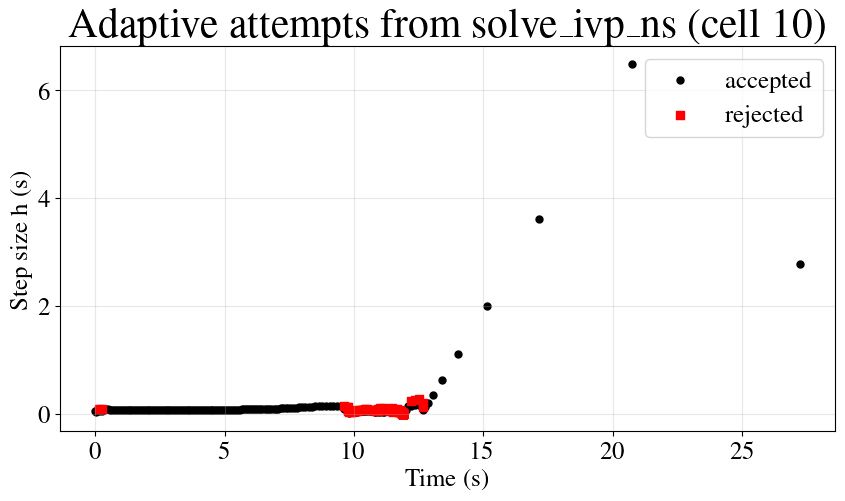

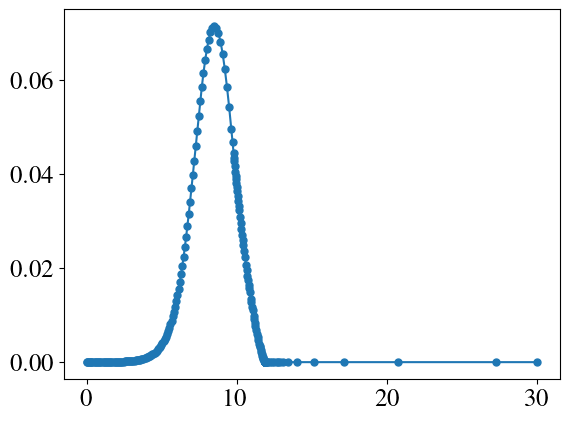

In [83]:
# Visualize adaptive attempts from solve_ivp_ns (accepted vs rejected)
if ssn_attempts["t_raw"].size:
    t_phys = ssn_attempts["t_phys"]
    h_phys = ssn_attempts["dt_phys"]
    acc_mask = ssn_attempts["accepted"]

    plt.figure(figsize=(10, 5))
    plt.scatter(t_phys[acc_mask], h_phys[acc_mask], color="black", s=25, label="accepted")
    plt.scatter(t_phys[~acc_mask], h_phys[~acc_mask], color="red", marker="s", s=30, label="rejected")
    plt.xlabel("Time (s)")
    plt.ylabel("Step size h (s)")
    plt.title("Adaptive attempts from solve_ivp_ns (cell 10)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("solve_ivp_ns did not record any adaptive attempts (is adaptive disabled?)")# plt.plot(t_vals_ssn * fault.Tscale / fault.second, np.mean(y_vals_ssn[:,:N_DOFS],axis=1) * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title('Velocity vs Time (SSN)')
# # plt.legend()
# plt.grid()
# plt.show()

# plt.plot(t_vals_ssn * fault.Tscale / fault.second,y_vals_ssn[:,:N_DOFS] * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Timemarkert# .ylabel('Velocity (m/s)')
plt# .title('Velocity vs Time (SSN)')
# p# lt.legend()
plt# .grid()
plt# .show()
t_scaled = t_vals_ssn * fault.Tscale / fault.second
mean_vel = np.mean(y_vals_ssn[:, :N_DOFS], axis=1) * fault.Vscale

plt.plot(t_scaled, mean_vel, linestyle='-', color='C0', label='Velocity (ssn)')
plt.scatter(t_scaled, mean_vel, color='C0', s=25)  # one marker per time point

In [84]:
t_vals_ssn[-1] * fault.Tscale / fault.second

np.float64(30.0)

In [85]:
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# print(v_max)
# # print(0.07/fault.Vscale)

In [86]:
import numpy as np
# # alpha_reference = 2.0  # legacy default retained for reference
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# # print(v_max)


import numpy as np

def build_reward_fn(alpha_value: float):
    """
    Build a reward function parameterized by alpha_value.

    alpha_value controls how harshly we punish numerical error via A = exp(-alpha*E).
    Larger alpha_value => more accuracy-obsessed agent.
    """

    alpha_value = float(alpha_value)

    def my_reward_fn(solver_perf, dt_attempt, xk, env):
        # solver_perf layout from env.increment_env:
        # [ runtime_inc,
        #   dts,
        #   error_LO,
        #   error_lil1,
        #   error_HI,
        #   E,                # global RMS scaled error
        #   success_LO,
        #   success_lil1,
        #   success_HI,
        #   kiter_LO,
        #   iter_lil1,
        #   kiter_HI ]
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # We'll need this a few times
        dt_range = env.dt_max - env.dt_min

        # If the integrator did not advance time (reject / failure path):
        # dts will be 0.0, success flags likely False.
        if dts == 0.0:
            # Penalize requesting a too-large step that got rejected.
            # Normalize dt_attempt to [0,1] and assign negative reward.
            dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
            # Clip to be safe
            # dt_norm_attempt = float(np.clip(dt_norm_attempt, 0.0, 1.0))
            # print(f" Step rejected. dt_attempt: {dt_attempt}, dt_norm_attempt: {dt_norm_attempt}")
            return -dt_norm_attempt  # more aggressive ask that failed => more negative

        # Otherwise: this step was accepted and advanced time by dts.

        # -----------------
        # S1: step size score
        # -----------------
        # We reward taking a large *accepted* step.
        dt_norm = (dts - env.dt_min) / dt_range
        S1 = float(np.clip(dt_norm, 0.0, 1.0))

        # -----------------
        # S2: runtime score
        # -----------------
        # Track per-step runtime and update the running maximum to normalize S2 dynamically
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))

        # Maintain a running max runtime seen so far
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        # track min as well as max
        if not hasattr(env, 'min_runtime_seen'):
            env.min_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc < env.min_runtime_seen:
                env.min_runtime_seen = float(runtime_inc)
        # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
        rt_min =  float(env.min_runtime_seen)
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom

        A = float(np.exp(-alpha_value * E))
        # print(f" S1: {S1}, S2: {S2},  A: {A}")
        # Final reward
        reward = S1 * S2 * A
        return reward

    return my_reward_fn



def build_obs_fn(alpha_value: float):
    """
    Factory that returns an observation function using the SAME alpha as the reward.
    This keeps reward shaping and observation aligned.

    The returned function will be called as:
        obs_fn(dt_attempt, converged, xk, solver_perf, fk, env)

    Where:
      - dt_attempt: the candidate step the agent just asked for (float or None at reset)
      - converged: 1 if the accepted high-accuracy solve succeeded, else 0 (None at reset)
      - xk: current state vector after the env step (or initial state at reset)
      - solver_perf: list of solver diagnostics from env.increment_env(...) (None at reset)
      - fk: current residual (not used here, but passed in by env)
      - env: the AdaptiveStepperEnv instance
    """
    alpha_value = float(alpha_value)

    def my_obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None, "env must be provided by AdaptiveStepperEnv"

        # ------------------------------------------------------------------
        # 1. Extract physics state features from xk
        # ------------------------------------------------------------------
        n = N_DOFS  # assuming N_DOFS is defined in outer scope
        v = xk[:n]          # velocities / slip rates
        u = xk[n:2*n]       # displacements / slips

        avg_v = float(np.mean(v))

        # Internal elastic energy 0.5 * u^T K u
        ks_u = KS @ u       # KS must be defined in outer scope
        E_int = 0.5 * float(np.dot(u, ks_u))

        # Normalize internal energy by Uintc (critical energy), if available and >0
        try:
            if Uintc > 0.0:
                E_norm = float(E_int / Uintc)
            else:
                E_norm = float(E_int)
        except NameError:
            # Fallback if Uintc isn't in scope
            E_norm = float(E_int)

        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0
        # ------------------------------------------------------------------
        # 2. Reset branch (env.reset calls us with dt_attempt=None, solver_perf=None)
        # ------------------------------------------------------------------
        if dt_attempt is None or solver_perf is None:
            # We still return a valid 6-D observation vector.
            # Fill in placeholders for solver-derived quantities.
            dt_norm_default = 0.5  # neutral midpoint in [0,1]
            conv_flag = 0.0 if converged is None else float(converged)

            return np.array([
                E_norm,                # elastic energy normalized
                avg_v / (0.07/fault.Vscale),         # avg slip rate normalized (v_max provided externally)
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag,             # "converged" flag at reset (0 or None -> 0)
                0.0,                   # exp(-alpha * 0) = 1.0 as a neutral accuracy proxy
                conv_flag_bipolar * dt_norm_default,       # normalized dt ~ mid
            ], dtype=np.float64)

        # ------------------------------------------------------------------
        # 3. Normal step branch: unpack solver_perf
        # ------------------------------------------------------------------
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E_global,        # global RMS scaled error (Richardson)
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # ------------------------------------------------------------------
        # 4. Normalize dt_attempt into [0,1]
        # ------------------------------------------------------------------
        dt_range = env.dt_max - env.dt_min
        if dt_range <= 0.0:
            dt_norm = 0.0
        else:
            dt_norm = (dt_attempt - env.dt_min) / dt_range
            dt_norm = float(np.clip(dt_norm, 0.0, 1.0))

        # ------------------------------------------------------------------
        # 5. Accuracy proxy, aligned with reward shaping
        # ------------------------------------------------------------------
        # 6. Convergence flag
        # ------------------------------------------------------------------
        # env.step sets converged = 1 if dts > 0 else 0 before calling obs_fn.
        conv_flag = float(converged) if converged is not None else 0.0
        if conv_flag:
            acc = 1/(1 + E_global)
        else:
            # print(f"Not converged step detected in obs_fn.")
            acc = 0.0

        # print(f"E_norm: {E_norm}, avg_v/v_max: {avg_v / v_max}, iter_error: {(env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0}, conv_flag: {conv_flag}, acc: {acc}, dt_norm: {dt_norm}")
        # ------------------------------------------------------------------
        # 7. Assemble observation vector
        # ------------------------------------------------------------------
        # print(f"observed step {conv_flag_bipolar*dt_norm}")
        return np.array([
            E_norm,                        # normalized elastic energy
            avg_v / (0.07/fault.Vscale),                 # normalized average slip rate
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag,                     # 1 if high-accuracy solve accepted, else 0
            acc,                   # exp(-alpha * error), same shaping as reward
            conv_flag_bipolar *dt_norm,                       # normalized proposed dt in [0,1]
        ], dtype=np.float64)

    return my_obs_fn


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(
        self,
        Vscale=1.0,
        Dscale=1.0,
        Tscale=1.0,
        update_freq=50,
        offset_increment=10.0,
        num_envs=1,
        verbose=0,
    ):
        """
        Live training monitor for SB3 in Jupyter.

        Panels per env:
          (0) step-by-step reward trace, with green vertical lines at episode ends
          (1) per-episode return
          (2) avg_v (green, left y) and avg_u (blue, right y) vs physical time t_k1,
              zoomed to last ~2-3 episodes
          (3) steps_per_episode (here we record Sim_time at episode end)

        Vscale, Dscale, Tscale are just multiplicative scalars in case your units
        are nondimensional internally and you want to rescale for plotting.
        """
        super().__init__(verbose)
        self.update_freq = int(update_freq)
        self.offset_increment = float(offset_increment)

        self.Vscale = float(Vscale)  # scales avg_v
        self.Dscale = float(Dscale)  # scales avg_u
        self.Tscale = float(Tscale)  # not currently used in plot, reserved

        # will get overwritten in _init_callback
        self.num_envs = int(num_envs)

        # buffers (will be resized in _init_callback)
        self.rewards = None
        self.episode_rewards = None
        self.current_episode_rewards = None

        self.avg_v_values = None
        self.avg_u_values = None
        self.t_k1_values = None

        self.steps = None
        self.episodes = None
        self.episode_end_steps = None
        self.episode_end_indices = None
        self.current_offsets = None
        self.steps_per_episode = None

        self.fig = None
        self.axs = None     # shape [num_envs][4]
        self.axs2 = None    # list of twin y-axes, len = num_envs

    def _init_callback(self) -> None:
        """Called by SB3 at the beginning of .learn()."""
        # detect actual number of envs from VecEnv
        self.num_envs = getattr(self.training_env, "num_envs", 1)

        # allocate buffers for each env
        self.rewards = [[] for _ in range(self.num_envs)]               # step-wise reward
        self.episode_rewards = [[] for _ in range(self.num_envs)]       # per-episode return
        self.current_episode_rewards = [0.0] * self.num_envs            # running sum this ep

        self.avg_v_values = [[] for _ in range(self.num_envs)]          # avg_v trace
        self.avg_u_values = [[] for _ in range(self.num_envs)]          # avg_u trace
        self.t_k1_values  = [[] for _ in range(self.num_envs)]          # physical time trace (offset per ep)

        self.steps = [0] * self.num_envs
        self.episodes = [0] * self.num_envs

        self.episode_end_steps   = [[] for _ in range(self.num_envs)]   # x-locations of ep ends in panel 0
        self.episode_end_indices = [[] for _ in range(self.num_envs)]   # indices for trimming panel 2
        self.current_offsets     = [0.0] * self.num_envs                # time offset added after each ep
        self.steps_per_episode   = [[] for _ in range(self.num_envs)]   # store Sim_time snapshot at ep end

        # set up figure
        self.fig, self.axs = plt.subplots(self.num_envs, 4, figsize=(25, 5 * self.num_envs))
        if self.num_envs == 1:
            # normalize shape so we can always index axs[i][col]
            self.axs = [self.axs]

        # make twin y-axes for avg_u in panel (2)
        self.axs2 = []
        for i in range(self.num_envs):
            # panel 0: reward vs steps
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")

            # panel 1: per-episode return
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # panel 2: avg_v / avg_u vs t_k1
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # panel 3: steps_per_episode
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

            ax2 = self.axs[i][2].twinx()
            ax2.set_ylabel("avg_u", color="b")
            ax2.tick_params(axis="y", labelcolor="b")
            self.axs2.append(ax2)

        display(self.fig)

    def _on_step(self) -> bool:
        """
        Called by SB3 every environment step (actually every rollout collection step).

        We read self.locals["rewards"], self.locals["dones"], self.locals["infos"].
        With VecEnv:
            rewards -> np.array shape (n_envs,)
            dones   -> np.array shape (n_envs,)
            infos   -> list[dict] length n_envs
        With single env:
            they can be scalars/dicts; we wrap them to lists.
        """
        rewards = self.locals["rewards"]
        dones   = self.locals["dones"]
        infos   = self.locals["infos"]

        # unify shape for num_envs==1
        if self.num_envs == 1 and not isinstance(rewards, (list, tuple, np.ndarray)):
            rewards = [rewards]
            dones   = [dones]
            infos   = [infos]

        for i in range(self.num_envs):
            r_i = float(rewards[i])
            self.rewards[i].append(r_i)
            self.current_episode_rewards[i] += r_i
            self.steps[i] += 1

            info_i = infos[i]


            xk = info_i.get("xk", None)
            if xk is not None:
                n = N_DOFS
                v = xk[:n]* self.Vscale
                u = xk[n:2*n]* self.Dscale
            #     mean_vel.append(float(np.mean(v)))
            # mean_slip.append(float(np.mean(u)))

            # # pull diagnostics from env.info
            # # we scaled in env.step(), now we optionally rescale for plotting
            # avg_v_i  = float(info_i.get("avg_v", 0.0)) * self.Vscale
            # avg_u_i  = float(info_i.get("avg_u", 0.0)) * self.Dscale
            t_k1_i   = float(info_i.get("t_k1", 0.0))
            sim_time = float(info_i.get("Sim_time", 0.0))

            # append traces
            self.avg_v_values[i].append(float(np.mean(v)))
            self.avg_u_values[i].append(float(np.mean(u)))
            # add offset to make t_k1 increase monotonically across episodes
            self.t_k1_values[i].append(t_k1_i + self.current_offsets[i])

            # handle episode boundary
            if dones[i]:
                # store episode return
                self.episode_rewards[i].append(self.current_episode_rewards[i])
                # mark step index where this episode ended
                self.episode_end_steps[i].append(len(self.rewards[i]))
                # mark index in avg_v_values so we can "zoom to last 2-3 episodes"
                self.episode_end_indices[i].append(len(self.avg_v_values[i]))

                # snapshot "steps per episode" panel: we're using sim_time here
                self.steps_per_episode[i].append(sim_time)

                # reset accumulators for next ep
                self.current_episode_rewards[i] = 0.0
                self.episodes[i] += 1
                self.steps[i] = 0

                # bump offset so next episode's t_k1 timeline is shifted forward
                if self.t_k1_values[i]:
                    last_t = self.t_k1_values[i][-1]
                    self.current_offsets[i] = last_t + self.offset_increment

        # redraw occasionally
        total_steps_all_envs = sum(self.steps)
        if (total_steps_all_envs % self.update_freq) == 0:
            self._update_plot()

        return True

    def _update_plot(self):
        """Refresh the 4-panel figure for each env."""
        for i in range(self.num_envs):
            # clear each panel
            self.axs[i][0].cla()
            self.axs[i][1].cla()
            self.axs[i][2].cla()
            self.axs2[i].cla()
            self.axs[i][3].cla()

            # (0) reward per step, with episode boundaries
            self.axs[i][0].plot(self.rewards[i], "b-")
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")
            for step_idx in self.episode_end_steps[i]:
                self.axs[i][0].axvline(x=step_idx, color="g", linestyle="--")

            # (1) episode return
            if len(self.episode_rewards[i]) > 1:
                self.axs[i][1].plot(
                    self.episode_rewards[i][1:],
                    color="r",
                    marker="o",
                    linestyle="-",
                )
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # choose window for panel (2): last ~2-3 episodes
            if len(self.episode_end_indices[i]) >= 3:
                start_index = self.episode_end_indices[i][-3]
            elif len(self.episode_end_indices[i]) == 2:
                start_index = self.episode_end_indices[i][-2]
            else:
                start_index = 0
            end_index = len(self.avg_v_values[i])

            # (2) avg_v vs physical time
            self.axs[i][2].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_v_values[i][start_index:end_index],
                color="g",
                marker="o",
                linestyle="-",
                label="avg_v",
            )
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # (2 twin) avg_u vs physical time
            self.axs2[i].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_u_values[i][start_index:end_index],
                color="b",
                marker="x",
                linestyle="--",
                label="avg_u",
            )
            self.axs2[i].set_ylabel("avg_u", color="b")
            self.axs2[i].tick_params(axis="y", labelcolor="b")

            # combined legend
            lines_1, labels_1 = self.axs[i][2].get_legend_handles_labels()
            lines_2, labels_2 = self.axs2[i].get_legend_handles_labels()
            self.axs[i][2].legend(
                lines_1 + lines_2,
                labels_1 + labels_2,
                loc="upper left",
            )

            # (3) steps_per_episode (we're storing Sim_time snapshots)
            if len(self.steps_per_episode[i]) > 1:
                self.axs[i][3].plot(self.steps_per_episode[i][1:], "b-")
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

        clear_output(wait=True)
        display(self.fig)


In [88]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod, Trapezoidal
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from Solve_IVP_NS.rl.callbacks import CustomMetricsCallback
from gymnasium import spaces
from pathlib import Path
import json
from copy import deepcopy

from stable_baselines3.common.noise import NormalActionNoise


# Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]
component_slices_solver = [slice(0, 3 * N_DOFS)]  # solver works on full state vector
# For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
rhok = np.ones(N_DOFS, dtype=float)

# Create the projection operator
projection = CoulombProjection(
    con_force_func=con_force,
    rhok=rhok,
    component_slices=component_slices,
    constraint_indices=np.arange(N_DOFS, dtype=np.int32),
    use_numba=True,  # use Numba acceleration
    jac_func=con_force_jacobian,  # analytical Jacobian for CoulombProjection
)

# Configure the implicit solver
solver_mp = ImplicitEquationSolver(
    method='VI',
    proj=projection,
    component_slices=component_slices,
    tol=solver_opts_ssn.get('tol', 1e-6),
    max_iter=solver_opts_ssn.get('max_iter', 50),
    vi_strict_block_lipschitz=solver_opts_ssn.get("vi_strict_block_lipschitz", False),
    vi_max_block_adjust_iters=solver_opts_ssn.get("vi_max_block_adjust_iters", 10),
)
solver_mp.rhs_jacobian = rhs_jac  # expose analytical RHS Jacobian to integrators

# Use the composite method (which calls the solver internally)
method_mp = CompositeMethod(solver=solver_mp, A=A)



# --- Adaptive RL training over an alpha sweep ---
# Here we iterate over a list of alpha values, train a policy for each,
# and persist the resulting models, normalization stats, and metadata
# into per-alpha subdirectories for easy organization.
dt0 = 1e-3
t0 = t_span[0]
tnmax = t_span[1]
dt_min = 1e-6  # * fault.second / fault.Tscale
dt_max = 30 / 5 * fault.second / fault.Tscale
nparams = (1e-6, 100)

# Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
obs_dim = 6
obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

# alpha_grid = [0.5, 1.0, 2.0, 4.0,8.0, 16.0, 32.0, 128.0]  # customize as desired
# alpha_grid = [ 32.0, 128.0]  # customize as desired

alpha_grid = [8.0]  # customize as desired

total_timesteps = 20_000
RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP")
RUN_ROOT.mkdir(parents=True, exist_ok=True)

def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

_base_policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64], n_critics=5)
)



In [89]:
reward_callback = RewardCallback(num_envs=1,Vscale = fault.Vscale, Dscale = fault.Dscale, Tscale = fault.Tscale/fault.second, update_freq=100)




In [90]:
# from pathlib import Path
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from sb3_contrib import TQC
# from stable_baselines3 import TD3
# import time

# try:
#     import pandas as pd
#     from IPython.display import display
#     _HAVE_PANDAS = True
# except Exception:
#     _HAVE_PANDAS = False

# # ---------------------------------------------------------------------------
# # Configuration for baseline PI controller
# # ---------------------------------------------------------------------------
# adaptive_opts_2 = dict(
#     h0=5e-3,
#     h_min=1e-7,
#     h_down=0.6,
#     h_up=1.8,
#     method_order=1,        # p = 1 → nonsmooth first-order scheme, so k = p+1 = 2
#     controller="h211b",    # PI digital filter variant
#     mode="ratio",
#     b_param=4.0,           # only if controller == "H211b"
#     skip_error_indices=[],
# )

# def _alpha_label(alpha_value: float) -> str:
#     sign = "m" if alpha_value < 0 else ""
#     magnitude = str(abs(alpha_value)).replace(".", "p")
#     return f"{sign}{magnitude}"

# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()

# ALGO_REGISTRY = {
#     "TQC": TQC,
#     # "TD3": TD3,  # uncomment if you also want TD3
# }

# # Discover trained runs (alpha_*), then filter alpha=2 only
# alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
# alpha_dirs = [d for d in alpha_dirs if "alpha_2" in d.name or "alpha_2p0" in d.name]

# if not alpha_dirs:
#     raise FileNotFoundError(
#         f"No alpha=2 trained runs found under {RUN_ROOT}. Expected folder like alpha_2p0/"
#     )

# print(f"Found alpha=2 directories: {[d.name for d in alpha_dirs]}")

# dt0 = 1e-3

# # ---------------------------------------------------------------------------
# # Helper: rebuild the same environment used for training
# # ---------------------------------------------------------------------------
# def make_eval_env(reward_fn, obs_fn, alpha_value: float):
#     return AdaptiveStepperEnv(
#         system=rhs,
#         dt0=dt0,
#         t0=0.0,
#         x0=y0,
#         tnmax=tnmax,
#         dt_min=dt_min,
#         dt_max=dt_max,
#         nparams=nparams,
#         integrator=method_mp,
#         component_slices=component_slices,
#         reward_fn=reward_fn,
#         obs_fn=obs_fn,
#         obs_space=obs_space,
#         verbose=False,
#         alpha=alpha_value,
#     )

# # ---------------------------------------------------------------------------
# # Rollout of a trained policy on the environment
# #   - times: accepted times (code units)
# #   - mean_vel, mean_slip: DOF-averaged v,u at accepted times
# #   - hs: attempted step sizes in PHYSICAL units
# #   - ts2: times of attempts (code units)
# # ---------------------------------------------------------------------------
# def rollout_policy_on_env(model, env, run_name="(unnamed)"):
#     obs, info = env.reset()
#     times = []
#     mean_vel = []
#     mean_slip = []

#     hs = []   # PHYSICAL attempted step sizes
#     ts2 = []  # attempt times in code units

#     start = time.time()
#     done = False
#     term = False

#     last_t = None
#     repeat_count = 0
#     broke_stuck = False
#     last_converged = None

#     while not (done or term):
#         action, _ = model.predict(obs, deterministic=True)

#         # attempted step size in PHYSICAL units (your existing formula)
#         h_phys = ((action * (tnmax / 6.0 - 1e-6) + 1e-6)
#                   * fault.Tscale / 1000.0).squeeze()
#         hs.append(float(h_phys))

#         obs, reward, done, term, info = env.step(action)
#         t_now = info.get("t_k1", np.nan)

#         # record attempt time (code units)
#         if not np.isnan(t_now):
#             ts2.append(float(t_now))
#         else:
#             ts2.append(ts2[-1] if ts2 else 0.0)

#         # env convergence flag
#         if isinstance(info, dict) and ("converged" in info):
#             last_converged = info.get("converged")

#         # guard for repeated time
#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and np.isclose(current_t, last_t,
#                                                  rtol=0.0, atol=1e-12):
#                 repeat_count += 1
#                 if repeat_count >= 10:
#                     print(f"[{run_name}] WARNING: Time stuck at {current_t} "
#                           f"for 10 iterations, breaking loop")
#                     broke_stuck = True
#                     break
#             else:
#                 repeat_count = 0
#             last_t = current_t

#         # accepted state
#         xk = info.get("xk", None)
#         if xk is not None:
#             n = N_DOFS
#             v = xk[:n]
#             u = xk[n:2*n]
#             times.append(float(t_now))
#             mean_vel.append(float(np.mean(v)))
#             mean_slip.append(float(np.mean(u)))

#     wall = time.time() - start

#     # success test
#     tnmax_val = getattr(env, 'tnmax', None)
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         if len(times) > 0 and tnmax_val is not None:
#             success = (times[-1] >= 0.999 * float(tnmax_val)) and not broke_stuck
#         else:
#             success = not broke_stuck

#     return (
#         np.asarray(times),
#         np.asarray(mean_vel),
#         np.asarray(mean_slip),
#         wall,
#         success,
#         np.asarray(hs),   # physical step sizes
#         np.asarray(ts2),  # attempt times (code units)
#     )

# # ---------------------------------------------------------------------------
# # Evaluate all alpha=2 policies
# # ---------------------------------------------------------------------------
# series = {}  # key -> dict(times, mean_v, mean_u, runtime, h_attempts, ts_attempts, ...)

# for alpha_dir in alpha_dirs:
#     algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
#     if not algo_dirs:
#         print(f"Skipping {alpha_dir.name}: no algorithm runs found")
#         continue
#     for algo_dir in algo_dirs:
#         algo_name = algo_dir.name
#         ModelClass = ALGO_REGISTRY.get(algo_name)
#         if ModelClass is None:
#             print(f"Skipping {algo_dir}: unknown algorithm '{algo_name}'")
#             continue

#         meta_path = algo_dir / "metadata.json"
#         model_path_zip = algo_dir / "model.zip"
#         model_path_plain = algo_dir / "model"

#         if not meta_path.exists():
#             print(f"Skipping {algo_dir}: missing metadata.json")
#             continue
#         with open(meta_path, "r", encoding="utf-8") as fh:
#             meta = json.load(fh)
#         alpha_value = float(meta.get("alpha", np.nan))
#         if np.isnan(alpha_value):
#             try:
#                 alabel = alpha_dir.name.split("alpha_")[-1]
#                 alpha_value = float(alabel.replace("p", ".").replace("m", "-"))
#             except Exception:
#                 print(f"Could not infer alpha from {alpha_dir.name}; skipping {algo_dir}")
#                 continue

#         key = f"{algo_name} alpha={alpha_value:g}"
#         print(f"Evaluating {key} from {(algo_dir.relative_to(RUN_ROOT))}...")

#         reward_fn = build_reward_fn(alpha_value)
#         obs_fn = build_obs_fn(alpha_value)
#         env = make_eval_env(reward_fn, obs_fn, alpha_value)

#         mdl_path = str(model_path_zip) if model_path_zip.exists() else str(model_path_plain)
#         if not Path(mdl_path).exists():
#             print(f"Skipping {algo_dir}: no model found at {model_path_zip} or {model_path_plain}")
#             continue
#         model = ModelClass.load(mdl_path, device="cpu")

#         try:
#             runtimes = []
#             success_runs = []
#             for run_idx in range(1):  # increase if you want averaging
#                 t_arr, v_mean, u_mean, wall, success, h_attempts, ts_attempts = rollout_policy_on_env(
#                     model, env, run_name=key
#                 )
#                 runtimes.append(wall)
#                 success_runs.append(bool(success))
#                 if run_idx == 0:
#                     t_arr_store = t_arr
#                     v_mean_store = v_mean
#                     u_mean_store = u_mean
#                     h_attempts_store = h_attempts
#                     ts_attempts_store = ts_attempts

#             avg_runtime = float(np.mean(runtimes))
#             std_runtime = float(np.std(runtimes))
#             any_success = any(success_runs)
#             print(
#                 f"Finished {key}: avg_wall={avg_runtime:.3f}s ± {std_runtime:.3f}s, "
#                 f"steps={len(t_arr_store)}, "
#                 f"t_end={(t_arr_store[-1] if len(t_arr_store)>0 else 'NA')}, "
#                 f"converged_any={any_success}"
#             )
#             series[key] = {
#                 "times": t_arr_store,
#                 "mean_v": v_mean_store,
#                 "mean_u": u_mean_store,
#                 "runtime_s": avg_runtime,
#                 "runtime_std": std_runtime,
#                 "converged": bool(any_success),
#                 "h_attempts": h_attempts_store,
#                 "ts_attempts": ts_attempts_store,
#                 # RL env does not expose an explicit accepted flag
#                 "attempt_accepted": [],   # keep key for JSON symmetry
#             }
#         except Exception as e:
#             print(f"FAILED {key}: {e}")
#             continue

# # ---------------------------------------------------------------------------
# # Baseline: adaptive integrator using Solve_IVP_NS.solve_ivp_ns
# # Now uses return_attempts=True and logs t, dt, accepted, error, status.
# # ---------------------------------------------------------------------------
# def adaptive_integrator_baseline():
#     """
#     Run the PI-based adaptive integrator once and return:
#         t_store, v_b, u_b, avg_runtime_b, std_runtime_b,
#         success_b, h_attempts_phys, ts_attempts_code, attempt_accepted

#     where h_attempts_phys and ts_attempts_code come from the
#     solve_ivp_ns attempt log (dt, t) and attempt_accepted is the
#     boolean mask for each attempt.
#     """
#     runtimes_b = []
#     t_store = None
#     y_store = None
#     h_attempts_phys = None
#     ts_attempts_code = None
#     attempt_accepted = None

#     for run_idx in range(1):
#         try:
#             if run_idx == 0:
#                 # use cached values if they exist, but re-run to capture attempts
#                 t_vals_b = t_vals_ssn
#                 y_vals_b = y_vals_ssn
#                 wall_b = rt_nb
#                 raise NameError
#             else:
#                 raise NameError
#         except NameError:
#             start_b = time.time()
#             projection_opts_nb = dict(projection_opts)
#             projection_opts_nb["use_numba"] = True

#             # IMPORTANT: request attempt logging
#             result = Solve_IVP_NS.solve_ivp_ns(
#                 fun=rhs,
#                 t_span=t_span,
#                 y0=y0,
#                 method="composite",
#                 projection="coulomb",
#                 solver="VI",
#                 projection_opts=projection_opts_nb,
#                 solver_opts=solver_opts_ssn,
#                 adaptive=True,
#                 adaptive_opts=adaptive_opts_2,
#                 h0=adaptive_opts["h0"],
#                 component_slices=component_slices,
#                 verbose=True,
#                 A=A,
#                 return_attempts=True,   # <---- NEW
#             )
#             wall_b = time.time() - start_b

#             if len(result) != 6:
#                 raise ValueError(
#                     f"solve_ivp_ns returned {len(result)} values; expected 6 "
#                     f"(t, y, h_vals, fk_vals, solver_info, attempt_log)."
#                 )

#             (t_vals_b, y_vals_b,
#              h_vals_b, fk_vals_b,
#              solver_info_b, attempt_log) = result

#             # attempt_log is a dict: {"t", "dt", "accepted", "error", "status", ...}
#             at_t = np.asarray(attempt_log.get("t", []), dtype=float)
#             at_dt = np.asarray(attempt_log.get("dt", []), dtype=float)
#             at_acc = np.asarray(attempt_log.get("accepted", []), dtype=bool)

#             ts_attempts_code = at_t                    # still in code units
#             h_attempts_phys = at_dt * fault.Tscale / fault.second
#             attempt_accepted = at_acc

#         runtimes_b.append(wall_b)
#         if run_idx == 0:
#             t_store = t_vals_b
#             y_store = y_vals_b

#     n = N_DOFS
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)

#     avg_runtime_b = float(np.mean(runtimes_b))
#     std_runtime_b = float(np.std(runtimes_b))
#     print(f"Adaptive integrator: avg_wall={avg_runtime_b:.3f}s ± {std_runtime_b:.3f}s")

#     success_b = (len(t_store) > 0 and t_store[-1] >= 0.999 * t_span[1])

#     if h_attempts_phys is None:
#         h_attempts_phys = np.array([])
#     if ts_attempts_code is None:
#         ts_attempts_code = np.array([])
#     if attempt_accepted is None:
#         attempt_accepted = np.array([], dtype=bool)

#     return (t_store, v_b, u_b,
#             avg_runtime_b, std_runtime_b, success_b,
#             h_attempts_phys, ts_attempts_code, attempt_accepted)

# try:
#     (t_b, v_b, u_b,
#      wall_b, wall_b_std, succ_b,
#      h_attempts_b_phys, ts_attempts_b, accepted_b) = adaptive_integrator_baseline()

#     series["adaptive_integrator"] = {
#         "times": np.asarray(t_b),
#         "mean_v": np.asarray(v_b),
#         "mean_u": np.asarray(u_b),
#         "runtime_s": float(wall_b),
#         "runtime_std": float(wall_b_std),
#         "converged": bool(succ_b),
#         "h_attempts": np.asarray(h_attempts_b_phys),
#         "ts_attempts": np.asarray(ts_attempts_b),
#         "attempt_accepted": np.asarray(accepted_b, bool),
#     }
# except Exception as e:
#     print(f"Could not get attempts from baseline solve_ivp_ns: {e}")
#     t_b = t_vals_ssn
#     v_b = np.mean(y_vals_ssn[:, :N_DOFS], axis=1)
#     u_b = np.mean(y_vals_ssn[:, N_DOFS:2*N_DOFS], axis=1)
#     wall_b = rt_nb
#     wall_b_std = 0.0
#     succ_b = True
#     series["adaptive_integrator"] = {
#         "times": np.asarray(t_b),
#         "mean_v": np.asarray(v_b),
#         "mean_u": np.asarray(u_b),
#         "runtime_s": float(wall_b),
#         "runtime_std": float(wall_b_std),
#         "converged": bool(succ_b),
#         "h_attempts": np.array([]),
#         "ts_attempts": np.array([]),
#         "attempt_accepted": np.array([], dtype=bool),
#     }

# # ---------------------------------------------------------------------------
# # SAVE 'series' TO DISK IN A JSON-FRIENDLY FORMAT
# # ---------------------------------------------------------------------------
# def series_to_jsonable(series_dict):
#     out = {}
#     for name, data in series_dict.items():
#         out[name] = {
#             "times": np.asarray(data["times"], float).tolist(),
#             "mean_v": np.asarray(data["mean_v"], float).tolist(),
#             "mean_u": np.asarray(data["mean_u"], float).tolist(),
#             "runtime_s": float(data["runtime_s"]),
#             "runtime_std": float(data["runtime_std"]),
#             "converged": bool(data["converged"]),
#             "h_attempts": np.asarray(data["h_attempts"], float).tolist(),
#             "ts_attempts": np.asarray(data["ts_attempts"], float).tolist(),
#             # NEW: explicit accepted flags for the baseline
#             "attempt_accepted": np.asarray(
#                 data.get("attempt_accepted", []), bool
#             ).tolist(),
#         }
#     return out

# series_json = series_to_jsonable(series)
# output_series_path = RUN_ROOT / "series_alpha2.json"
# with open(output_series_path, "w", encoding="utf-8") as fh:
#     json.dump(series_json, fh, indent=2)
# print(f"\nSaved series data to {output_series_path}")


In [91]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import TQC
from stable_baselines3 import TD3
import time

try:
    import pandas as pd
    from IPython.display import display
    _HAVE_PANDAS = True
except Exception:
    _HAVE_PANDAS = False

# ---------------------------------------------------------------------------
# Configuration for baseline PI controller
# ---------------------------------------------------------------------------
adaptive_opts_2 = dict(
    h0=5e-3,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,        # p = 1 → nonsmooth first-order scheme, so k = p+1 = 2
    controller="h211b",    # PI digital filter variant
    mode="ratio",
    b_param=4.0,           # only if controller == "H211b"
    skip_error_indices=[],
)

def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()

ALGO_REGISTRY = {
    "TQC": TQC,
    # "TD3": TD3,  # uncomment if you also want TD3
}

# Discover trained runs (alpha_*), then filter alpha=2 only
alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
alpha_dirs = [d for d in alpha_dirs if "alpha_2" in d.name or "alpha_2p0" in d.name]

if not alpha_dirs:
    raise FileNotFoundError(
        f"No alpha=2 trained runs found under {RUN_ROOT}. Expected folder like alpha_2p0/"
    )

print(f"Found alpha=2 directories: {[d.name for d in alpha_dirs]}")

dt0 = 1e-3

# ---------------------------------------------------------------------------
# Helper: rebuild the same environment used for training
# ---------------------------------------------------------------------------
def make_eval_env(reward_fn, obs_fn, alpha_value: float):
    return AdaptiveStepperEnv(
        system=rhs,
        dt0=dt0,
        t0=0.0,
        x0=y0,
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=reward_fn,
        obs_fn=obs_fn,
        obs_space=obs_space,
        verbose=False,
        alpha=alpha_value,
    )

# ---------------------------------------------------------------------------
# Rollout of a trained policy on the environment
#   - times: accepted times (code units)
#   - mean_vel, mean_slip: DOF-averaged v,u at accepted times (already physical)
#   - hs: attempted step sizes in PHYSICAL units
#   - ts2: times of attempts (code units)
#   - v_field, u_field: full spatial fields (physical units) at accepted times
# ---------------------------------------------------------------------------
def rollout_policy_on_env(model, env, run_name="(unnamed)"):
    obs, info = env.reset()
    times = []
    mean_vel = []
    mean_slip = []

    hs = []   # PHYSICAL attempted step sizes
    ts2 = []  # attempt times in code units

    # NEW: store full fields for later spatial plots
    v_fields = []   # (N_steps, N_DOFS)
    u_fields = []   # (N_steps, N_DOFS)

    start = time.time()
    done = False
    term = False

    last_t = None
    repeat_count = 0
    broke_stuck = False
    last_converged = None

    while not (done or term):
        action, _ = model.predict(obs, deterministic=True)

        # attempted step size in PHYSICAL units (your existing formula)
        h_phys = ((action * (tnmax / 6.0 - 1e-6) + 1e-6)
                  * fault.Tscale / 1000.0).squeeze()
        hs.append(float(h_phys))

        obs, reward, done, term, info = env.step(action)
        t_now = info.get("t_k1", np.nan)

        # record attempt time (code units)
        if not np.isnan(t_now):
            ts2.append(float(t_now))
        else:
            ts2.append(ts2[-1] if ts2 else 0.0)

        # env convergence flag
        if isinstance(info, dict) and ("converged" in info):
            last_converged = info.get("converged")

        # guard for repeated time
        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and np.isclose(
                current_t, last_t, rtol=0.0, atol=1e-12
            ):
                repeat_count += 1
                if repeat_count >= 10:
                    print(
                        f"[{run_name}] WARNING: Time stuck at {current_t} "
                        f"for 10 iterations, breaking loop"
                    )
                    broke_stuck = True
                    break
            else:
                repeat_count = 0
            last_t = current_t

        # accepted state (xk is already in PHYSICAL units in your env)
        xk = info.get("xk", None)
        if xk is not None:
            n = N_DOFS
            v = xk[:n]
            u = xk[n:2*n]

            # averages (already physical)
            times.append(float(t_now))
            mean_vel.append(float(np.mean(v)))
            mean_slip.append(float(np.mean(u)))

            # NEW: store full spatial fields
            v_fields.append(np.array(v, copy=True))
            u_fields.append(np.array(u, copy=True))

    wall = time.time() - start

    # success test
    tnmax_val = getattr(env, 'tnmax', None)
    if last_converged is not None:
        success = bool(last_converged)
    else:
        if len(times) > 0 and tnmax_val is not None:
            success = (times[-1] >= 0.999 * float(tnmax_val)) and not broke_stuck
        else:
            success = not broke_stuck

    return (
        np.asarray(times),
        np.asarray(mean_vel),
        np.asarray(mean_slip),
        wall,
        success,
        np.asarray(hs),        # physical step sizes
        np.asarray(ts2),       # attempt times (code units)
        np.asarray(v_fields),  # full velocity field (physical)
        np.asarray(u_fields),  # full slip field (physical)
    )

# ---------------------------------------------------------------------------
# Evaluate all alpha=2 policies
# ---------------------------------------------------------------------------
series = {}  # key -> dict(times, mean_v, mean_u, runtime, h_attempts, ts_attempts, ...)

for alpha_dir in alpha_dirs:
    algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
    if not algo_dirs:
        print(f"Skipping {alpha_dir.name}: no algorithm runs found")
        continue
    for algo_dir in algo_dirs:
        algo_name = algo_dir.name
        ModelClass = ALGO_REGISTRY.get(algo_name)
        if ModelClass is None:
            print(f"Skipping {algo_dir}: unknown algorithm '{algo_name}'")
            continue

        meta_path = algo_dir / "metadata.json"
        model_path_zip = algo_dir / "model.zip"
        model_path_plain = algo_dir / "model"

        if not meta_path.exists():
            print(f"Skipping {algo_dir}: missing metadata.json")
            continue
        with open(meta_path, "r", encoding="utf-8") as fh:
            meta = json.load(fh)
        alpha_value = float(meta.get("alpha", np.nan))
        if np.isnan(alpha_value):
            try:
                alabel = alpha_dir.name.split("alpha_")[-1]
                alpha_value = float(alabel.replace("p", ".").replace("m", "-"))
            except Exception:
                print(f"Could not infer alpha from {alpha_dir.name}; skipping {algo_dir}")
                continue

        key = f"{algo_name} alpha={alpha_value:g}"
        print(f"Evaluating {key} from {(algo_dir.relative_to(RUN_ROOT))}...")

        reward_fn = build_reward_fn(alpha_value)
        obs_fn = build_obs_fn(alpha_value)
        env = make_eval_env(reward_fn, obs_fn, alpha_value)

        mdl_path = str(model_path_zip) if model_path_zip.exists() else str(model_path_plain)
        if not Path(mdl_path).exists():
            print(f"Skipping {algo_dir}: no model found at {model_path_zip} or {model_path_plain}")
            continue
        model = ModelClass.load(mdl_path, device="cpu")

        try:
            runtimes = []
            success_runs = []
            for run_idx in range(1):  # increase if you want averaging
                (t_arr, v_mean, u_mean,
                 wall, success,
                 h_attempts, ts_attempts,
                 v_field, u_field) = rollout_policy_on_env(
                    model, env, run_name=key
                )
                runtimes.append(wall)
                success_runs.append(bool(success))
                if run_idx == 0:
                    t_arr_store       = t_arr
                    v_mean_store      = v_mean
                    u_mean_store      = u_mean
                    h_attempts_store  = h_attempts
                    ts_attempts_store = ts_attempts
                    v_field_store     = v_field    # full fields
                    u_field_store     = u_field

            avg_runtime = float(np.mean(runtimes))
            std_runtime = float(np.std(runtimes))
            any_success = any(success_runs)
            print(
                f"Finished {key}: avg_wall={avg_runtime:.3f}s ± {std_runtime:.3f}s, "
                f"steps={len(t_arr_store)}, "
                f"t_end={(t_arr_store[-1] if len(t_arr_store)>0 else 'NA')}, "
                f"converged_any={any_success}"
            )
            series[key] = {
                "times": t_arr_store,
                "mean_v": v_mean_store,
                "mean_u": u_mean_store,
                "runtime_s": avg_runtime,
                "runtime_std": std_runtime,
                "converged": bool(any_success),
                "h_attempts": h_attempts_store,
                "ts_attempts": ts_attempts_store,
                # RL env does not expose an explicit accepted flag
                "attempt_accepted": [],   # keep key for JSON symmetry

                # NEW: full spatial fields at accepted times (physical units)
                "v_field": v_field_store,
                "u_field": u_field_store,
            }
        except Exception as e:
            print(f"FAILED {key}: {e}")
            continue

# ---------------------------------------------------------------------------
# Baseline: adaptive integrator using Solve_IVP_NS.solve_ivp_ns
# Now uses return_attempts=True and logs t, dt, accepted, error, status.
# ---------------------------------------------------------------------------
def adaptive_integrator_baseline():
    """
    Run the PI-based adaptive integrator once and return:
        t_store, v_b, u_b, avg_runtime_b, std_runtime_b,
        success_b, h_attempts_phys, ts_attempts_code, attempt_accepted

    where h_attempts_phys and ts_attempts_code come from the
    solve_ivp_ns attempt log (dt, t) and attempt_accepted is the
    boolean mask for each attempt.
    """
    runtimes_b = []
    t_store = None
    y_store = None
    h_attempts_phys = None
    ts_attempts_code = None
    attempt_accepted = None

    for run_idx in range(1):
        try:
            if run_idx == 0:
                # use cached values if they exist, but re-run to capture attempts
                t_vals_b = t_vals_ssn
                y_vals_b = y_vals_ssn
                wall_b = rt_nb
                raise NameError
            else:
                raise NameError
        except NameError:
            start_b = time.time()
            projection_opts_nb = dict(projection_opts)
            projection_opts_nb["use_numba"] = True

            # IMPORTANT: request attempt logging
            result = Solve_IVP_NS.solve_ivp_ns(
                fun=rhs,
                t_span=t_span,
                y0=y0,
                method="composite",
                projection="coulomb",
                solver="VI",
                projection_opts=projection_opts_nb,
                solver_opts=solver_opts_ssn,
                adaptive=True,
                adaptive_opts=adaptive_opts_2,
                h0=adaptive_opts["h0"],
                component_slices=component_slices,
                verbose=False,
                A=A,
                return_attempts=True,   # <---- NEW
            )
            wall_b = time.time() - start_b

            if len(result) != 6:
                raise ValueError(
                    f"solve_ivp_ns returned {len(result)} values; expected 6 "
                    f"(t, y, h_vals, fk_vals, solver_info, attempt_log)."
                )

            (t_vals_b, y_vals_b,
             h_vals_b, fk_vals_b,
             solver_info_b, attempt_log) = result

            # attempt_log is a dict: {"t", "dt", "accepted", "error", "status", ...}
            at_t = np.asarray(attempt_log.get("t", []), dtype=float)
            at_dt = np.asarray(attempt_log.get("dt", []), dtype=float)
            at_acc = np.asarray(attempt_log.get("accepted", []), dtype=bool)

            ts_attempts_code = at_t                    # still in code units
            h_attempts_phys = at_dt * fault.Tscale / fault.second
            attempt_accepted = at_acc

        runtimes_b.append(wall_b)
        if run_idx == 0:
            t_store = t_vals_b
            y_store = y_vals_b

    n = N_DOFS
    v_b = np.mean(y_store[:, :n], axis=1)
    u_b = np.mean(y_store[:, n:2*n], axis=1)

    avg_runtime_b = float(np.mean(runtimes_b))
    std_runtime_b = float(np.std(runtimes_b))
    print(f"Adaptive integrator: avg_wall={avg_runtime_b:.3f}s ± {std_runtime_b:.3f}s")

    success_b = (len(t_store) > 0 and t_store[-1] >= 0.999 * t_span[1])

    if h_attempts_phys is None:
        h_attempts_phys = np.array([])
    if ts_attempts_code is None:
        ts_attempts_code = np.array([])
    if attempt_accepted is None:
        attempt_accepted = np.array([], dtype=bool)

    return (t_store, v_b, u_b,
            avg_runtime_b, std_runtime_b, success_b,
            h_attempts_phys, ts_attempts_code, attempt_accepted)

try:
    (t_b, v_b, u_b,
     wall_b, wall_b_std, succ_b,
     h_attempts_b_phys, ts_attempts_b, accepted_b) = adaptive_integrator_baseline()

    series["adaptive_integrator"] = {
        "times": np.asarray(t_b),
        "mean_v": np.asarray(v_b),
        "mean_u": np.asarray(u_b),
        "runtime_s": float(wall_b),
        "runtime_std": float(wall_b_std),
        "converged": bool(succ_b),
        "h_attempts": np.asarray(h_attempts_b_phys),
        "ts_attempts": np.asarray(ts_attempts_b),
        "attempt_accepted": np.asarray(accepted_b, bool),
        # keep v_field/u_field absent or empty; they’re only needed for RL
        # "v_field": np.array([]),
        # "u_field": np.array([]),
    }
except Exception as e:
    print(f"Could not get attempts from baseline solve_ivp_ns: {e}")
    t_b = t_vals_ssn
    v_b = np.mean(y_vals_ssn[:, :N_DOFS], axis=1)
    u_b = np.mean(y_vals_ssn[:, N_DOFS:2*N_DOFS], axis=1)
    wall_b = rt_nb
    wall_b_std = 0.0
    succ_b = True
    series["adaptive_integrator"] = {
        "times": np.asarray(t_b),
        "mean_v": np.asarray(v_b),
        "mean_u": np.asarray(u_b),
        "runtime_s": float(wall_b),
        "runtime_std": float(wall_b_std),
        "converged": bool(succ_b),
        "h_attempts": np.array([]),
        "ts_attempts": np.array([]),
        "attempt_accepted": np.array([], dtype=bool),
    }

# ---------------------------------------------------------------------------
# SAVE 'series' TO DISK IN A JSON-FRIENDLY FORMAT
# ---------------------------------------------------------------------------
def series_to_jsonable(series_dict):
    out = {}
    for name, data in series_dict.items():
        entry = {
            "times": np.asarray(data["times"], float).tolist(),
            "mean_v": np.asarray(data["mean_v"], float).tolist(),
            "mean_u": np.asarray(data["mean_u"], float).tolist(),
            "runtime_s": float(data["runtime_s"]),
            "runtime_std": float(data["runtime_std"]),
            "converged": bool(data["converged"]),
            "h_attempts": np.asarray(data["h_attempts"], float).tolist(),
            "ts_attempts": np.asarray(data["ts_attempts"], float).tolist(),
            # explicit accepted flags for the baseline
            "attempt_accepted": np.asarray(
                data.get("attempt_accepted", []), bool
            ).tolist(),
        }

        # NEW: include full fields if present (RL runs)
        if "v_field" in data:
            entry["v_field"] = np.asarray(data["v_field"], float).tolist()
        if "u_field" in data:
            entry["u_field"] = np.asarray(data["u_field"], float).tolist()

        out[name] = entry
    return out

series_json = series_to_jsonable(series)
output_series_path = RUN_ROOT / "series_alpha2.json"
with open(output_series_path, "w", encoding="utf-8") as fh:
    json.dump(series_json, fh, indent=2)
print(f"\nSaved series data to {output_series_path}")


Found alpha=2 directories: ['alpha_2p0']
Skipping /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/TEST_RL_ALPHA_SWEEP/alpha_2p0/TD3: unknown algorithm 'TD3'
Evaluating TQC alpha=2 from alpha_2p0/TQC...
Finished TQC alpha=2: avg_wall=44.753s ± 0.000s, steps=22, t_end=38.17411230951493, converged_any=True
coulomb
Adaptive integrator: avg_wall=415.307s ± 0.000s

Saved series data to /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/TEST_RL_ALPHA_SWEEP/series_alpha2.json


Heuristic entry (a): adaptive_integrator
RL entry (c):        TQC alpha=2
Saved 3-panel step-attempt figure to: /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/TEST_RL_ALPHA_SWEEP/time_step_evolution_comparison.pdf


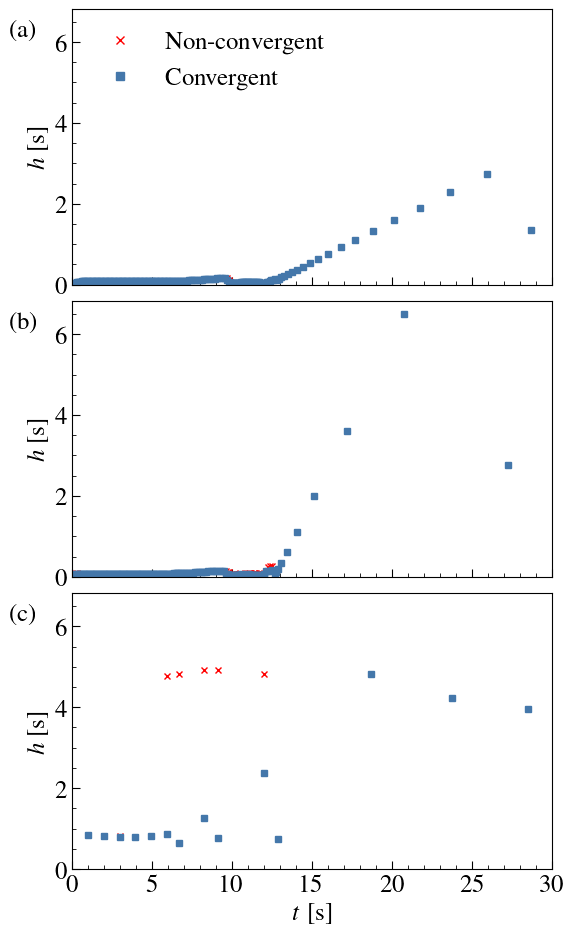

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict

# ------------------------------------------------------------
# 0) Global style: uniform fonts
# ------------------------------------------------------------
sizes = 18
plt.rcParams.update({
    "font.size": sizes,
    "axes.labelsize": sizes,
    "xtick.labelsize": sizes,
    "ytick.labelsize": sizes,
    "legend.fontsize": sizes,
    "text.usetex": True,
    "font.family": "Times",
})

# ------------------------------------------------------------
# 1) Identify heuristic and RL entries from `series`
# ------------------------------------------------------------
heur_key = None    # baseline / adaptive integrator  → panel (a)
rl_key   = None    # RL controller (e.g. TQC alpha=2) → panel (c)

for name in series.keys():
    lname = name.lower()
    if "adaptive_integrator" in lname:
        heur_key = name
    if ("alpha=" in name) and (rl_key is None):
        rl_key = name

if heur_key is None:
    raise RuntimeError("Could not find 'adaptive_integrator' entry in series.")
if rl_key is None:
    raise RuntimeError("Could not find any RL entry with 'alpha=' in series.")

print(f"Heuristic entry (a): {heur_key}")
print(f"RL entry (c):        {rl_key}")

# ------------------------------------------------------------
# 2) Helper: classify attempts (physical units)
# ------------------------------------------------------------
def classify_attempts_phys(t_phys, h_phys, accepted_mask=None):
    """
    Parameters
    ----------
    t_phys : array-like
        Physical times in seconds (one per attempt).
    h_phys : array-like
        Attempted step sizes in seconds.
    accepted_mask : array-like of bool or None
        If provided, True = accepted / convergent, False = rejected.
        If None, we infer:
            for each time, smallest h is accepted, larger ones rejected.

    Returns
    -------
    t_acc, h_acc, t_rej, h_rej : np.ndarray
        Accepted (convergent) and rejected (non-convergent) attempts.
    """
    t_phys = np.asarray(t_phys, float)
    h_phys = np.asarray(h_phys, float)

    if accepted_mask is not None and len(accepted_mask) > 0:
        accepted_mask = np.asarray(accepted_mask, bool)

        # Ensure same length
        n = min(t_phys.size, h_phys.size, accepted_mask.size)
        t_phys = t_phys[:n]
        h_phys = h_phys[:n]
        accepted_mask = accepted_mask[:n]

        mask_finite = np.isfinite(t_phys) & np.isfinite(h_phys)
        t_phys = t_phys[mask_finite]
        h_phys = h_phys[mask_finite]
        accepted_mask = accepted_mask[mask_finite]

        t_acc = t_phys[accepted_mask]
        h_acc = h_phys[accepted_mask]
        t_rej = t_phys[~accepted_mask]
        h_rej = h_phys[~accepted_mask]
        return t_acc, h_acc, t_rej, h_rej

    # --- Fallback: infer by time grouping (used for RL) ---
    mask = np.isfinite(t_phys) & np.isfinite(h_phys)
    t_phys = t_phys[mask]
    h_phys = h_phys[mask]

    if t_phys.size == 0 or h_phys.size == 0:
        return (np.array([]), np.array([]),
                np.array([]), np.array([]))

    groups = defaultdict(list)
    for t, h in zip(t_phys, h_phys):
        t_key = round(float(t), 8)  # group times with small tolerance
        groups[t_key].append(h)

    t_acc, h_acc, t_rej, h_rej = [], [], [], []

    for t_key, hs in groups.items():
        hs = np.asarray(hs, float)
        if hs.size == 1:
            # Only one attempt at this time → accepted
            t_acc.append(t_key)
            h_acc.append(hs[0])
        else:
            # Smallest h = accepted, any larger h = rejected
            idx_min = np.argmin(hs)
            acc_h = hs[idx_min]
            rej_h = np.delete(hs, idx_min)

            t_acc.append(t_key)
            h_acc.append(acc_h)
            t_rej.extend([t_key] * rej_h.size)
            h_rej.extend(rej_h.tolist())

    return (np.asarray(t_acc),
            np.asarray(h_acc),
            np.asarray(t_rej),
            np.asarray(h_rej))

# ------------------------------------------------------------
# 3) Build physical time/h arrays for each panel
#    (a) heuristic   : series[heur_key] (has attempt_accepted)
#    (b) new control : t_attempt_pi, h_attempt_pi, accepted_attempt_mask
#    (c) RL          : series[rl_key] (no accepted flags)
# ------------------------------------------------------------

# (a) heuristic / adaptive integrator
heur = series[heur_key]
t_code_h = heur["ts_attempts"] if np.asarray(heur["ts_attempts"]).size else heur["times"]
t_phys_h = np.asarray(t_code_h, float) * fault.Tscale / fault.second
h_phys_h = np.asarray(heur["h_attempts"], float)  # already physical (s)
accepted_h = np.asarray(heur.get("attempt_accepted", []), bool)

# (b) new controller style (semismooth run with logging)
#     t_attempt_pi, h_attempt_pi, accepted_attempt_mask are already in physical units.
t_phys_new = np.asarray(t_attempt_pi, float)            # times of attempts [s]
h_phys_new = np.asarray(h_attempt_pi, float)            # attempted dt [s]
accepted_new = np.asarray(accepted_attempt_mask, bool)  # True/False per attempt

# (c) RL
rl = series[rl_key]
t_code_r = rl["ts_attempts"] if np.asarray(rl["ts_attempts"]).size else rl["times"]
t_phys_r = np.asarray(t_code_r, float) * fault.Tscale / fault.second
h_phys_r = np.asarray(rl["h_attempts"], float)          # physical (s)
accepted_rl = None   # no flags → infer via min-h rule

# Classify each set
t_acc_h, h_acc_h, t_rej_h, h_rej_h = classify_attempts_phys(t_phys_h,   h_phys_h, accepted_h)
t_acc_b, h_acc_b, t_rej_b, h_rej_b = classify_attempts_phys(t_phys_new, h_phys_new, accepted_new)
t_acc_r, h_acc_r, t_rej_r, h_rej_r = classify_attempts_phys(t_phys_r,   h_phys_r, accepted_rl)

# Global y-limits
arrays_for_ylim = [h_acc_h, h_rej_h, h_acc_b, h_rej_b, h_acc_r, h_rej_r]
if any(arr.size for arr in arrays_for_ylim):
    all_h_vals = np.concatenate([arr for arr in arrays_for_ylim if arr.size])
else:
    all_h_vals = np.array([0.0, 1.0])

ymin = 0.0
ymax = 1.05 * float(np.max(all_h_vals))

# ------------------------------------------------------------
# 4) Create 3×1 figure with shared x-axis
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(6.0, 10.0), sharex=True)
fig.subplots_adjust(left=0.18, right=0.98, bottom=0.12, top=0.98, hspace=0.06)

for ax in axes:
    ax.minorticks_on()
    ax.tick_params(axis="both", which="both", direction="in")
    ax.tick_params(axis="both", which="major", length=6)
    ax.tick_params(axis="both", which="minor", length=3)
    ax.grid(False)
    ax.set_xlim(0.0, 30.0)
    ax.set_ylim(ymin, ymax)
    ax.margins(x=0.02, y=0.05)

color_acc = "#4477AA"  # blue squares (Convergent)
color_rej = "red"      # red crosses (Non-convergent)

# -------------------------
# Panel (a): heuristic PI controller
# -------------------------
ax = axes[0]

if t_rej_h.size:
    ax.plot(t_rej_h, h_rej_h,
            linestyle="None", marker="x",
            color=color_rej, markersize=5)

if t_acc_h.size:
    ax.plot(t_acc_h, h_acc_h,
            linestyle="None", marker="s",
            color=color_acc, markersize=5)

ax.set_ylabel(r"$h$ [s]")
ax.text(-0.13, 0.96, r"(a)", transform=ax.transAxes,
        ha="left", va="top")

# Legend: always show both markers, even if no rejected steps occurred
legend_handles = [
    Line2D([], [], linestyle="None", marker="x",
           color=color_rej, markersize=6, label="Non-convergent"),
    Line2D([], [], linestyle="None", marker="s",
           color=color_acc, markersize=6, label="Convergent"),
]
ax.legend(handles=legend_handles, frameon=False, loc="upper left")

# -------------------------
# Panel (b): new controller style
# -------------------------
ax = axes[1]

if t_rej_b.size:
    ax.plot(t_rej_b, h_rej_b,
            linestyle="None", marker="x",
            color=color_rej, markersize=5)

if t_acc_b.size:
    ax.plot(t_acc_b, h_acc_b,
            linestyle="None", marker="s",
            color=color_acc, markersize=5)

ax.set_ylabel(r"$h$ [s]")
ax.text(-0.13, 0.96, r"(b)", transform=ax.transAxes,
        ha="left", va="top")

# -------------------------
# Panel (c): RL controller
# -------------------------
ax = axes[2]

if t_rej_r.size:
    ax.plot(t_rej_r, h_rej_r,
            linestyle="None", marker="x",
            color=color_rej, markersize=5)

if t_acc_r.size:
    ax.plot(t_acc_r, h_acc_r,
            linestyle="None", marker="s",
            color=color_acc, markersize=5)

ax.set_ylabel(r"$h$ [s]")
ax.set_xlabel(r"$t$ [s]")
ax.text(-0.13, 0.96, r"(c)", transform=ax.transAxes,
        ha="left", va="top")

out_path = RUN_ROOT / "time_step_evolution_comparison.pdf"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved 3-panel step-attempt figure to: {out_path}")
plt.show()


In [93]:
# import json
# import numpy as np
# from pathlib import Path

# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
# series_path = RUN_ROOT / "series_alpha2.json"

# with open(series_path, "r", encoding="utf-8") as fh:
#     series_json = json.load(fh)

# # Rebuild numpy arrays for convenience
# series_loaded = {}
# for name, data in series_json.items():
#     series_loaded[name] = {
#         "times": np.asarray(data["times"], float),
#         "mean_v": np.asarray(data["mean_v"], float),
#         "mean_u": np.asarray(data["mean_u"], float),
#         "runtime_s": float(data["runtime_s"]),
#         "runtime_std": float(data["runtime_std"]),
#         "converged": bool(data["converged"]),
#         "h_attempts": np.asarray(data["h_attempts"], float),
#         "ts_attempts": np.asarray(data["ts_attempts"], float),
#         "attempt_accepted": np.asarray(data["attempt_accepted"], bool),
#     }

# # Access baseline (heuristic PI)
# baseline = series_loaded["adaptive_integrator"]
# t_pi = baseline["times"]          # code units
# v_pi = baseline["mean_v"]
# u_pi = baseline["mean_u"]

# # Access an RL policy (e.g. TQC alpha=2)
# rl_key = [k for k in series_loaded.keys() if k.startswith("TQC")][0]
# rl_series = series_loaded[rl_key]
# t_rl = rl_series["times"]         # code units
# v_rl = rl_series["mean_v"]
# u_rl = rl_series["mean_u"]


# # 1) Path to constant-stepper results (adapt if you changed the name)
# results_dir = Path(".")  # or fault.result_dir if you store it
# const_file = results_dir / "constant_stepper_50by50.npz"  # example name

# if not const_file.exists():
#     raise FileNotFoundError(f"Constant-stepper file not found: {const_file}")

# # 2) Load constant-stepper data
# const = np.load(const_file)
# N=fault.N
# ts1_loaded = const["ts1"]   # constant-stepper times (code units)
# ys1_loaded = const["ys1"]   # constant-stepper states (shape (Nt_const, n_state))
# avg_v_constant = np.mean(ys1_loaded[:, :N], axis=1) * fault.Vscale
# avg_s_constant = np.mean(ys1_loaded[:,2*N:3*N], axis=1) * fault.Dscale
# t_const = ts1_loaded * fault.Tscale / 1000

In [94]:
def find_peak_matched_indices(t_const_sec, avg_v_const,
                              t_rl_sec, peak_frac=0.9):
    """
    Choose a snapshot near the peak of the constant-stepper average velocity,
    but also such that the RL time is as close as possible to that constant time.

    Parameters
    ----------
    t_const_sec : (Nc,) array
        Constant-stepper times in seconds.
    avg_v_const : (Nc,) array
        Constant-stepper average velocity (same shape as t_const_sec).
    t_rl_sec : (Nr,) array
        RL times in seconds.
    peak_frac : float
        Accept indices where avg_v_const >= peak_frac * max(avg_v_const).

    Returns
    -------
    idx_const : int
        Index in constant-stepper arrays.
    idx_rl : int
        Index in RL arrays.
    """
    t_const_sec = np.asarray(t_const_sec)
    t_rl_sec = np.asarray(t_rl_sec)
    avg_v_const = np.asarray(avg_v_const)

    # Peak of constant-stepper average velocity
    peak_idx = int(np.argmax(avg_v_const))
    peak_val = float(avg_v_const[peak_idx])

    # Candidate indices "near" the peak
    thresh = peak_frac * peak_val
    candidates = np.where(avg_v_const >= thresh)[0]
    if candidates.size == 0:
        candidates = np.arange(len(avg_v_const))

    best_i = None
    best_j = None
    best_dt = np.inf

    for i in candidates:
        dt_arr = np.abs(t_rl_sec - t_const_sec[i])
        j = int(np.argmin(dt_arr))
        dt = float(dt_arr[j])
        if dt < best_dt:
            best_dt = dt
            best_i = i
            best_j = j

    # Just in case
    if best_i is None:
        best_i = peak_idx
        best_j = int(np.argmin(np.abs(t_rl_sec - t_const_sec[best_i])))

    print(f"Peak-matched snapshot: t_const={t_const_sec[best_i]:.4f}s, "
          f"t_rl={t_rl_sec[best_j]:.4f}s, Δt={best_dt:.2e}s")

    return best_i, best_j


In [95]:
# import json
# import numpy as np
# from pathlib import Path
# import scipy.ndimage
# import matplotlib.pyplot as plt

# # ---------------------------------------------------------------------------
# # Load series_alpha2.json (RL + heuristic PI / baseline)
# # ---------------------------------------------------------------------------
# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
# series_path = RUN_ROOT / "series_alpha2.json"

# with open(series_path, "r", encoding="utf-8") as fh:
#     series_json = json.load(fh)

# # Rebuild numpy arrays, including full fields if present
# series_loaded = {}
# for name, data in series_json.items():
#     series_loaded[name] = {
#         "times": np.asarray(data["times"], float),          # code units
#         "mean_v": np.asarray(data["mean_v"], float),        # dimensionless or physical as stored
#         "mean_u": np.asarray(data["mean_u"], float),
#         "runtime_s": float(data["runtime_s"]),
#         "runtime_std": float(data["runtime_std"]),
#         "converged": bool(data["converged"]),
#         "h_attempts": np.asarray(data["h_attempts"], float),
#         "ts_attempts": np.asarray(data["ts_attempts"], float),
#         "attempt_accepted": np.asarray(data["attempt_accepted"], bool),
#         # full fields (may be empty for baseline)
#         "v_field": np.asarray(data.get("v_field", []), float),
#         "u_field": np.asarray(data.get("u_field", []), float),
#     }

# # ---------------------------------------------------------------------------
# # Extract heuristic PI (baseline) and RL series
# # ---------------------------------------------------------------------------
# # Heuristic PI baseline (called "Heuristic" in the figure)
# baseline = series_loaded["adaptive_integrator"]
# t_pi_code        = baseline["times"]        # code units
# avg_v_heuristic  = baseline["mean_v"]
# avg_s_heuristic  = baseline["mean_u"]

# # RL policy: first key starting with "TQC"
# rl_key_candidates = [k for k in series_loaded.keys() if k.startswith("TQC")]
# if not rl_key_candidates:
#     raise RuntimeError("No TQC RL series found in series_alpha2.json")
# rl_key = rl_key_candidates[0]

# rl_series = series_loaded[rl_key]
# t_rl_code  = rl_series["times"]            # code units
# avg_v_RL   = rl_series["mean_v"]
# avg_s_RL   = rl_series["mean_u"]
# v_rl_all   = rl_series["v_field"]          # shape (Nt_rl, N)
# u_rl_all   = rl_series["u_field"]

# if v_rl_all.size == 0:
#     raise RuntimeError("RL series has no v_field stored; did you rerun the saver code?")

# # ---------------------------------------------------------------------------
# # Load constant-stepper results (dimensionless state -> scale to physical)
# # ---------------------------------------------------------------------------
# results_dir = Path(".")  # or fault.result_dir if you store it there
# const_file = results_dir / "constant_stepper_25by25.npz"  # adapt if needed

# if not const_file.exists():
#     raise FileNotFoundError(f"Constant-stepper file not found: {const_file}")

# const = np.load(const_file)
# N = fault.N

# ts_const_code = const["ts1"]      # times (code units)
# ys_const      = const["ys1"]      # states (Nt_const, n_state)

# # Assume layout y = [v, ?, s, ...]; you were using [:N] and [2N:3N]
# v_const_all_dimless = ys_const[:, :N]
# s_const_all_dimless = ys_const[:, 2*N:3*N]

# # Scale to physical units using fault scalings
# v_const_all = v_const_all_dimless * fault.Vscale
# s_const_all = s_const_all_dimless * fault.Dscale

# # Averages for top-row plots
# avg_v_constant = np.mean(v_const_all, axis=1)
# avg_s_constant = np.mean(s_const_all, axis=1)

# # ---------------------------------------------------------------------------
# # Time conversion helpers
# # ---------------------------------------------------------------------------
# def to_seconds(t_code):
#     """Convert code time to seconds."""
#     return np.asarray(t_code) * fault.Tscale / 1000.0  # same convention as before

# def nearest_index_at_time(t_phys, t_target_sec):
#     """
#     Return index i such that t_phys[i] is closest to t_target_sec.
#     t_phys is already in seconds.
#     """
#     t_phys = np.asarray(t_phys)
#     return int(np.argmin(np.abs(t_phys - t_target_sec)))

# # Physical times for plotting
# t_const_sec = to_seconds(ts_const_code)
# t_pi_sec    = to_seconds(t_pi_code)
# t_rl_sec    = to_seconds(t_rl_code)

# # ---------------------------------------------------------------------------
# # Style: Tol "bright" palette + markers (consistent with your other figure)
# # ---------------------------------------------------------------------------
# COLORS = {
#     "constant": "#000000",  # black
#     "heuristic": "#4477AA", # strong blue
#     "rl": "#EE6677",        # vermillion/red
# }
# MARKERS = {
#     "heuristic": "s",  # square
#     "rl": "o",         # circle
# }

# # ---------------------------------------------------------------------------
# # Plotter for 2×2 figure
# #   (c) RL velocity field
# #   (d) relative error RL vs Constant
# # ---------------------------------------------------------------------------
# class MyPlotter:
#     def __init__(self, Nx, Nz, xlength, depth_ini, zdepth):
#         """
#         Nx, Nz: number of elements/nodes in x and z directions.
#         We assume N = Nx * Nz and DOF ordering with i + j * Nx.
#         """
#         self.Nx = Nx
#         self.Nz = Nz
#         self.N  = Nx * Nz
#         self.xlength   = xlength    # km
#         self.depth_ini = depth_ini  # km
#         self.zdepth    = zdepth     # km

#         # optional: store physical node coords if you have them
#         self.pts_x = None
#         self.pts_z = None

#     # ---------- meshing helpers ----------
#     def nop(self, i, j):
#         """DOF index from (i, j)."""
#         return i + j * self.Nx

#     def mesh_from_field(self, field_1d, smooth=3.0):
#         """
#         Take a 1D field of length Nx*Nz and return (x, y, z) for contourf.
#         """
#         field_1d = np.asarray(field_1d)
#         if field_1d.size != self.N:
#             raise ValueError(
#                 f"Field length {field_1d.size} does not match Nx*Nz={self.N}."
#             )

#         z = np.array(
#             [[field_1d[self.nop(i, j)] for i in range(self.Nx)]
#              for j in range(self.Nz)]
#         )

#         if smooth is not None and smooth > 1.0:
#             z = scipy.ndimage.zoom(z, smooth)

#         x, y = np.meshgrid(
#             np.linspace(0.0, self.xlength, z.shape[1], endpoint=True),
#             np.linspace(-self.depth_ini,
#                         -self.zdepth - self.depth_ini,
#                         z.shape[0],
#                         endpoint=True),
#         )
#         return x, y, z

#     def _extend_v(self, z, vmin=None, vmax=None):
#         extend = "neither"
#         if vmax is None:
#             vmax = z.max()
#         if vmin is None:
#             vmin = z.min()
#         if vmax < z.max():
#             extend = "max"
#         if vmin > z.min():
#             extend = "min"
#         if vmax < z.max() and vmin > z.min():
#             extend = "both"
#         if vmin == vmax:
#             vmax = vmin + 1.0
#         return extend, vmin, vmax

#     def plot_contour(self, ax, field_1d,
#                      vmin=None, vmax=None,
#                      cmap="Oranges",
#                      clabel="Velocity [m/s]",
#                      smooth=3.0,
#                      show_discretization=False):
#         x, y, z = self.mesh_from_field(field_1d, smooth=smooth)
#         extend, vmin, vmax = self._extend_v(z, vmin, vmax)
#         cf = ax.contourf(
#             x, y, z, levels=10,
#             cmap=plt.get_cmap(cmap),
#             vmin=vmin, vmax=vmax, extend=extend,
#         )
#         cb = plt.colorbar(cf, ax=ax)
#         cb.set_label(clabel)
#         if show_discretization and (self.pts_x is not None):
#             ax.plot(self.pts_x, -self.pts_z, "+", color="black", alpha=0.4)
#         ax.set_xlabel("x [km]")
#         ax.set_ylabel("z [km]")

#     # ---------- main 2×2 plot ----------
#     # ---------- main 2×2 plot ----------
#     def plot_2x2(self,
#                  t_const, avg_v_constant, avg_s_constant,
#                  t_pi, avg_v_heuristic, avg_s_heuristic,
#                  t_rl, avg_v_RL, avg_s_RL,
#                  v_const_all, v_rl_all,
#                  target_time=8.0):
#         """
#         t_* arrays are in SECONDS.
#         v_const_all, v_rl_all are (Nt, N) full velocity fields in physical units.
#         """

#         # indices of snapshot closest to target_time in each run
#         idx_const = nearest_index_at_time(t_const, target_time)
#         idx_rl    = nearest_index_at_time(t_rl,    target_time)

#         # snapshot fields
#         v_const_snap = v_const_all[idx_const, :]   # (N,)
#         v_rl_snap    = v_rl_all[idx_rl, :]         # (N,)

#         # relative error in %, avoid division-by-zero
#         eps = 1e-12
#         denom = np.where(np.abs(v_const_snap) < eps, eps, v_const_snap)
#         rel_err = (v_rl_snap - v_const_snap) / v_const_snap * 100.0

#         # convenient end time for x-axis and dashed extension
#         t_plot_end = 30.0
#         t_const_end = float(t_const[-1])
#         v_const_end = float(avg_v_constant[-1])
#         s_const_end = float(avg_s_constant[-1])

#         # Make 2×2 figure (publication style)
#         fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

#         # tick aesthetics on all panels
#         for ax in axs.flat:
#             ax.minorticks_on()
#             ax.tick_params(axis='both', which='both', direction='in')
#             ax.tick_params(axis='both', which='major', length=6)
#             ax.tick_params(axis='both', which='minor', length=3)
#             ax.grid(False)

#         # ---- (a) Average velocity ----
#         ax_a = axs[0, 0]
#         # Constant: solid line
#         ax_a.plot(t_const, avg_v_constant,
#                   color=COLORS["constant"],
#                   linewidth=2.5,
#                   label="Constant")
#         # Dashed extension of Constant to t=30 s
#         if t_const_end < t_plot_end:
#             ax_a.plot([t_const_end, t_plot_end],
#                       [v_const_end, v_const_end],
#                       linestyle="--",
#                       linewidth=2.0,
#                       color=COLORS["constant"])

#         # Heuristic: markers only
#         ax_a.plot(t_pi, avg_v_heuristic,
#                   linestyle='None',
#                   marker=MARKERS["heuristic"],
#                   markersize=8,
#                   markerfacecolor='none',
#                   markeredgecolor=COLORS["heuristic"],
#                   markeredgewidth=2.0,
#                   label="Heuristic")
#         # RL: markers only
#         ax_a.plot(t_rl, avg_v_RL,
#                   linestyle='None',
#                   marker=MARKERS["rl"],
#                   markersize=8,
#                   markerfacecolor='none',
#                   markeredgecolor=COLORS["rl"],
#                   markeredgewidth=2.0,
#                   label="RL")

#         # Origin point (0, 0) for velocity
#         ax_a.plot(0.0, 0.0, marker='o', markersize=5,
#                   color='k', zorder=10)

#         ax_a.set_ylabel("Average velocity [m/s]")
#         ax_a.set_xlabel("Time [s]")
#         ax_a.set_xlim(0, t_plot_end)
#         ax_a.margins(x=0.02, y=0.05)
#         ax_a.legend(loc="upper right", frameon=False)
#         ax_a.text(-0.15, 0.98, "(a)", transform=ax_a.transAxes,
#                   fontsize=12, va="top", ha="left")

#         # ---- (b) Average slip ----
#         ax_b = axs[0, 1]
#         ax_b.plot(t_const, avg_s_constant,
#                   color=COLORS["constant"],
#                   linewidth=2.5,
#                   label="Constant")
#         # Dashed extension of Constant to t=30 s
#         if t_const_end < t_plot_end:
#             ax_b.plot([t_const_end, t_plot_end],
#                       [s_const_end, s_const_end],
#                       linestyle="--",
#                       linewidth=2.0,
#                       color=COLORS["constant"])

#         ax_b.plot(t_pi, avg_s_heuristic,
#                   linestyle='None',
#                   marker=MARKERS["heuristic"],
#                   markersize=8,
#                   markerfacecolor='none',
#                   markeredgecolor=COLORS["heuristic"],
#                   markeredgewidth=2.0,
#                   label="Heuristic")
#         ax_b.plot(t_rl, avg_s_RL,
#                   linestyle='None',
#                   marker=MARKERS["rl"],
#                   markersize=8,
#                   markerfacecolor='none',
#                   markeredgecolor=COLORS["rl"],
#                   markeredgewidth=2.0,
#                   label="RL")

#         # Origin point (0, 0) for slip
#         ax_b.plot(0.0, 0.0, marker='o', markersize=5,
#                   color='k', zorder=10)

#         ax_b.set_ylabel("Average slip [mm]")   # adjust if needed
#         ax_b.set_xlabel("Time [s]")
#         ax_b.set_xlim(0, t_plot_end)
#         ax_b.margins(x=0.02, y=0.05)
#         ax_b.text(-0.15, 0.98, "(b)", transform=ax_b.transAxes,
#                   fontsize=12, va="top", ha="left")

#         # ---- (c) RL velocity field ----
#         ax_c = axs[1, 0]
#         self.plot_contour(
#             ax_c,
#             v_rl_snap,
#             cmap="Oranges",
#             clabel="Velocity [m/s]",
#         )
#         ax_c.text(-0.15, 0.98, "(c)", transform=ax_c.transAxes,
#                   fontsize=12, va="top", ha="left")

#         # ---- (d) Relative error RL vs Constant ----
#         ax_d = axs[1, 1]
#         self.plot_contour(
#             ax_d,
#             rel_err,
#             cmap="Oranges",
#             clabel="Relative Error [\%]",
#         )
#         ax_d.text(-0.15, 0.98, "(d)", transform=ax_d.transAxes,
#                   fontsize=12, va="top", ha="left")

#         fig.savefig("fault_2x2_RL_vs_const.png", dpi=300, bbox_inches="tight")
#         plt.show()


# # ---------------------------------------------------------------------------
# # Instantiate plotter and make the figure
# # ---------------------------------------------------------------------------
# plotter = MyPlotter(
#     Nx=25,               # 25×25 grid in your constant-stepper file
#     Nz=25,
#     xlength=3.0,         # km
#     depth_ini=0.0,       # km
#     zdepth=3.0,          # km
# )

# target_time =  7.72140983  # seconds

# # NOTE: heuristic/RL averages and fields are scaled here to physical units,
# # matching how you were doing it before.
# plotter.plot_2x2(
#     t_const=t_const_sec,
#     avg_v_constant=avg_v_constant,
#     avg_s_constant=avg_s_constant,
#     t_pi=t_pi_sec,
#     avg_v_heuristic=avg_v_heuristic * fault.Vscale,
#     avg_s_heuristic=avg_s_heuristic * fault.Dscale - np.mean(u0) * fault.Dscale,
#     t_rl=t_rl_sec,
#     avg_v_RL=avg_v_RL * fault.Vscale,
#     avg_s_RL=avg_s_RL * fault.Dscale - np.mean(u0) * fault.Dscale,
#     v_const_all=v_const_all,
#     v_rl_all=v_rl_all * fault.Vscale,
#     target_time=target_time,
# )


RL-peak-matched snapshot: t_rl=8.1967s, t_const=8.1839s, Δt=1.27e-02s


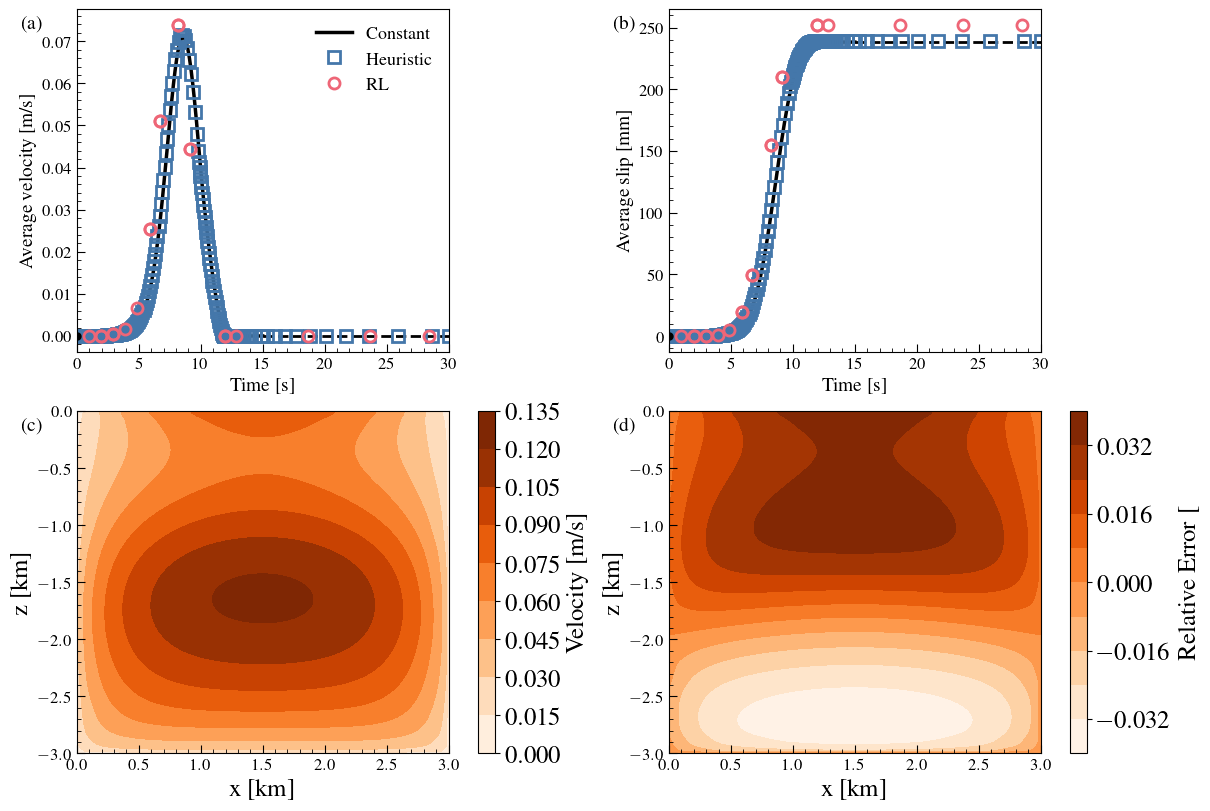

In [112]:
import json
import numpy as np
from pathlib import Path
import scipy.ndimage
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Load series_alpha2.json (RL + heuristic PI / baseline)
# ---------------------------------------------------------------------------
RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
series_path = RUN_ROOT / "series_alpha2.json"

with open(series_path, "r", encoding="utf-8") as fh:
    series_json = json.load(fh)

# Rebuild numpy arrays, including full fields if present
series_loaded = {}
for name, data in series_json.items():
    series_loaded[name] = {
        "times": np.asarray(data["times"], float),          # code units
        "mean_v": np.asarray(data["mean_v"], float),        # dimensionless or physical as stored
        "mean_u": np.asarray(data["mean_u"], float),
        "runtime_s": float(data["runtime_s"]),
        "runtime_std": float(data["runtime_std"]),
        "converged": bool(data["converged"]),
        "h_attempts": np.asarray(data["h_attempts"], float),
        "ts_attempts": np.asarray(data["ts_attempts"], float),
        "attempt_accepted": np.asarray(data["attempt_accepted"], bool),
        # full fields (may be empty for baseline)
        "v_field": np.asarray(data.get("v_field", []), float),
        "u_field": np.asarray(data.get("u_field", []), float),
    }

# ---------------------------------------------------------------------------
# Extract heuristic PI (baseline) and RL series
# ---------------------------------------------------------------------------
baseline = series_loaded["adaptive_integrator"]
t_pi_code        = baseline["times"]        # code units
avg_v_heuristic  = baseline["mean_v"]
avg_s_heuristic  = baseline["mean_u"]

# RL policy: first key starting with "TQC"
rl_key_candidates = [k for k in series_loaded.keys() if k.startswith("TQC")]
if not rl_key_candidates:
    raise RuntimeError("No TQC RL series found in series_alpha2.json")
rl_key = rl_key_candidates[0]

rl_series = series_loaded[rl_key]
t_rl_code  = rl_series["times"]            # code units
avg_v_RL   = rl_series["mean_v"]
avg_s_RL   = rl_series["mean_u"]
v_rl_all   = rl_series["v_field"]          # shape (Nt_rl, N)
u_rl_all   = rl_series["u_field"]

if v_rl_all.size == 0:
    raise RuntimeError("RL series has no v_field stored; did you rerun the saver code?")

# ---------------------------------------------------------------------------
# Load constant-stepper results (dimensionless state -> scale to physical)
# ---------------------------------------------------------------------------
results_dir = Path(".")  # or fault.result_dir if you store it there
const_file = results_dir / "constant_stepper_50by50.npz"  # adapt if needed

if not const_file.exists():
    raise FileNotFoundError(f"Constant-stepper file not found: {const_file}")

const = np.load(const_file)
N = fault.N

ts_const_code = const["ts1"]      # times (code units)
ys_const      = const["ys1"]      # states (Nt_const, n_state)

# layout y = [v, ?, s, ...]; using [:N] and [2N:3N]
v_const_all_dimless = ys_const[:, :N]
s_const_all_dimless = ys_const[:, 2 * N:3 * N]

# Scale to physical units using fault scalings
v_const_all = v_const_all_dimless * fault.Vscale
s_const_all = s_const_all_dimless * fault.Dscale

# Averages for top-row plots
avg_v_constant = np.mean(v_const_all, axis=1)
avg_s_constant = np.mean(s_const_all, axis=1)

# ---------------------------------------------------------------------------
# Time conversion helpers
# ---------------------------------------------------------------------------
def to_seconds(t_code):
    """Convert code time to seconds."""
    return np.asarray(t_code) * fault.Tscale / 1000.0

def nearest_index_at_time(t_phys, t_target_sec):
    """Return index i such that t_phys[i] is closest to t_target_sec (t_phys in seconds)."""
    t_phys = np.asarray(t_phys)
    return int(np.argmin(np.abs(t_phys - t_target_sec)))

# Physical times for plotting
t_const_sec = to_seconds(ts_const_code)
t_pi_sec    = to_seconds(t_pi_code)
t_rl_sec    = to_seconds(t_rl_code)

# ---------------------------------------------------------------------------
# Helper: use RL peak time, then snap constant to nearest time
# ---------------------------------------------------------------------------
def find_rl_peak_match(t_const_sec, t_rl_sec, avg_v_RL):
    """
    1. Find peak of RL average velocity.
    2. Use t_rl_peak as target time.
    3. Pick constant index closest to t_rl_peak.

    Returns
    -------
    idx_const, idx_rl : int
    """
    t_const_sec = np.asarray(t_const_sec)
    t_rl_sec = np.asarray(t_rl_sec)
    avg_v_RL = np.asarray(avg_v_RL)

    idx_rl = int(np.argmax(avg_v_RL))
    t_rl_peak = float(t_rl_sec[idx_rl])
    idx_const = int(np.argmin(np.abs(t_const_sec - t_rl_peak)))
    dt = abs(float(t_const_sec[idx_const]) - t_rl_peak)

    print(f"RL-peak-matched snapshot: t_rl={t_rl_peak:.4f}s, "
          f"t_const={t_const_sec[idx_const]:.4f}s, Δt={dt:.2e}s")

    return idx_const, idx_rl

# ---------------------------------------------------------------------------
# Style: Tol "bright" palette + markers (consistent with your other figure)
# ---------------------------------------------------------------------------
COLORS = {
    "constant":  "#000000",  # black
    "heuristic": "#4477AA",  # strong blue
    "rl":        "#EE6677",  # vermillion/red
}
MARKERS = {
    "heuristic": "s",  # square
    "rl":        "o",  # circle
}

# ---------------------------------------------------------------------------
# Plotter for 2×2 figure
# ---------------------------------------------------------------------------
class MyPlotter:
    def __init__(self, Nx, Nz, xlength, depth_ini, zdepth):
        self.Nx = Nx
        self.Nz = Nz
        self.N  = Nx * Nz
        self.xlength   = xlength    # km
        self.depth_ini = depth_ini  # km
        self.zdepth    = zdepth     # km
        self.pts_x = None
        self.pts_z = None

    # ---------- meshing helpers ----------
    def nop(self, i, j):
        return i + j * self.Nx

    def mesh_from_field(self, field_1d, smooth=3.0):
        field_1d = np.asarray(field_1d)
        if field_1d.size != self.N:
            raise ValueError(
                f"Field length {field_1d.size} does not match Nx*Nz={self.N}."
            )

        z = np.array(
            [[field_1d[self.nop(i, j)] for i in range(self.Nx)]
             for j in range(self.Nz)]
        )

        if smooth is not None and smooth > 1.0:
            z = scipy.ndimage.zoom(z, smooth)

        x, y = np.meshgrid(
            np.linspace(0.0, self.xlength, z.shape[1], endpoint=True),
            np.linspace(-self.depth_ini,
                        -self.zdepth - self.depth_ini,
                        z.shape[0],
                        endpoint=True),
        )
        return x, y, z

    def _extend_v(self, z, vmin=None, vmax=None):
        extend = "neither"
        if vmax is None:
            vmax = z.max()
        if vmin is None:
            vmin = z.min()
        if vmax < z.max():
            extend = "max"
        if vmin > z.min():
            extend = "min"
        if vmax < z.max() and vmin > z.min():
            extend = "both"
        if vmin == vmax:
            vmax = vmin + 1.0
        return extend, vmin, vmax

    def plot_contour(self, ax, field_1d,
                     vmin=None, vmax=None,
                     cmap="Oranges",
                     clabel="Velocity [m/s]",
                     smooth=3.0,
                     show_discretization=False):
        x, y, z = self.mesh_from_field(field_1d, smooth=smooth)
        extend, vmin, vmax = self._extend_v(z, vmin, vmax)
        cf = ax.contourf(
            x, y, z, levels=10,
            cmap=plt.get_cmap(cmap),
            vmin=vmin, vmax=vmax, extend=extend,
        )
        cb = plt.colorbar(cf, ax=ax)
        cb.set_label(clabel)
        if show_discretization and (self.pts_x is not None):
            ax.plot(self.pts_x, -self.pts_z, "+", color="black", alpha=0.4)
        ax.set_xlabel("x [km]")
        ax.set_ylabel("z [km]")

    # ---------- main 2×2 plot ----------
    def plot_2x2(self,
                 t_const, avg_v_constant, avg_s_constant,
                 t_pi, avg_v_heuristic, avg_s_heuristic,
                 t_rl, avg_v_RL, avg_s_RL,
                 v_const_all, v_rl_all):
        """
        t_* arrays are in SECONDS.
        v_const_all, v_rl_all are (Nt, N) full velocity fields in physical units.
        """

        # --- choose snapshot indices based on RL peak, then match constant ---
        idx_const, idx_rl = find_rl_peak_match(t_const, t_rl, avg_v_RL)

        v_const_snap = v_const_all[idx_const, :]   # (N,)
        v_rl_snap    = v_rl_all[idx_rl, :]         # (N,)

        # relative error in %, avoid division-by-zero
        eps = 1e-12
        denom = np.where(np.abs(v_const_snap) < eps, eps, v_const_snap)
        rel_err = (v_rl_snap - v_const_snap) #/ denom * 100.0

        # axis/time settings
        t_plot_end = 30.0
        t_const_end = float(t_const[-1])
        v_const_end = float(avg_v_constant[-1])
        s_const_end = float(avg_s_constant[-1])

        label_fs = 14
        tick_fs  = 12
        panel_fs = 14

        fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

        for ax in axs.flat:
            ax.minorticks_on()
            ax.tick_params(axis='both', which='both', direction='in',
                           labelsize=tick_fs)
            ax.tick_params(axis='both', which='major', length=6)
            ax.tick_params(axis='both', which='minor', length=3)
            ax.grid(False)

        # ---- (a) Average velocity ----
        ax_a = axs[0, 0]
        ax_a.plot(t_const, avg_v_constant,
                  color=COLORS["constant"],
                  linewidth=2.5,
                  label="Constant")
        if t_const_end < t_plot_end:
            ax_a.plot([t_const_end, t_plot_end],
                      [v_const_end, v_const_end],
                      linestyle="--",
                      linewidth=2.0,
                      color=COLORS["constant"])

        ax_a.plot(t_pi, avg_v_heuristic,
                  linestyle='None',
                  marker=MARKERS["heuristic"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["heuristic"],
                  markeredgewidth=2.0,
                  label="Heuristic")
        ax_a.plot(t_rl, avg_v_RL,
                  linestyle='None',
                  marker=MARKERS["rl"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["rl"],
                  markeredgewidth=2.0,
                  label="RL")

        ax_a.plot(0.0, 0.0, marker='o', markersize=5,
                  color='k', zorder=10)

        ax_a.set_ylabel("Average velocity [m/s]", fontsize=label_fs)
        ax_a.set_xlabel("Time [s]", fontsize=label_fs)
        ax_a.set_xlim(0, t_plot_end)
        ax_a.margins(x=0.02, y=0.05)
        ax_a.legend(loc="upper right", frameon=False, fontsize=label_fs-1)
        ax_a.text(-0.15, 0.98, "(a)", transform=ax_a.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        # ---- (b) Average slip ----
        ax_b = axs[0, 1]
        ax_b.plot(t_const, avg_s_constant,
                  color=COLORS["constant"],
                  linewidth=2.5,
                  label="Constant")
        if t_const_end < t_plot_end:
            ax_b.plot([t_const_end, t_plot_end],
                      [s_const_end, s_const_end],
                      linestyle="--",
                      linewidth=2.0,
                      color=COLORS["constant"])

        ax_b.plot(t_pi, avg_s_heuristic,
                  linestyle='None',
                  marker=MARKERS["heuristic"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["heuristic"],
                  markeredgewidth=2.0,
                  label="Heuristic")
        ax_b.plot(t_rl, avg_s_RL,
                  linestyle='None',
                  marker=MARKERS["rl"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["rl"],
                  markeredgewidth=2.0,
                  label="RL")

        ax_b.plot(0.0, 0.0, marker='o', markersize=5,
                  color='k', zorder=10)

        ax_b.set_ylabel("Average slip [mm]", fontsize=label_fs)
        ax_b.set_xlabel("Time [s]", fontsize=label_fs)
        ax_b.set_xlim(0, t_plot_end)
        ax_b.margins(x=0.02, y=0.05)
        ax_b.text(-0.15, 0.98, "(b)", transform=ax_b.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        # ---- (c) RL velocity field ----
        ax_c = axs[1, 0]
        self.plot_contour(
            ax_c,
            v_rl_snap,
            cmap="Oranges",
            clabel="Velocity [m/s]",
        )
        ax_c.text(-0.15, 0.98, "(c)", transform=ax_c.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        # ---- (d) Relative error RL vs Constant ----
        ax_d = axs[1, 1]
        self.plot_contour(
            ax_d,
            rel_err,
            cmap="Oranges",
            clabel="Relative Error [%]",
        )
        ax_d.text(-0.15, 0.98, "(d)", transform=ax_d.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        fig.savefig("fault_2x2_RL_vs_const.png", dpi=300, bbox_inches="tight")
        plt.show()

# ---------------------------------------------------------------------------
# Instantiate plotter and make the figure
# ---------------------------------------------------------------------------
plotter = MyPlotter(
    Nx=50,
    Nz=50,
    xlength=3.0,   # km
    depth_ini=0.0, # km
    zdepth=3.0,    # km
)

plotter.plot_2x2(
    t_const=t_const_sec,
    avg_v_constant=avg_v_constant,
    avg_s_constant=avg_s_constant,
    t_pi=t_pi_sec,
    avg_v_heuristic=avg_v_heuristic * fault.Vscale,
    avg_s_heuristic=avg_s_heuristic * fault.Dscale - np.mean(u0) * fault.Dscale,
    t_rl=t_rl_sec,
    avg_v_RL=avg_v_RL * fault.Vscale,
    avg_s_RL=avg_s_RL * fault.Dscale - np.mean(u0) * fault.Dscale,
    v_const_all=v_const_all,
    v_rl_all=v_rl_all * fault.Vscale,
)


RL peak at idx=11, t=8.1967s
Nearest constant time to RL peak: t_const=8.1839s, Δt=1.27e-02s


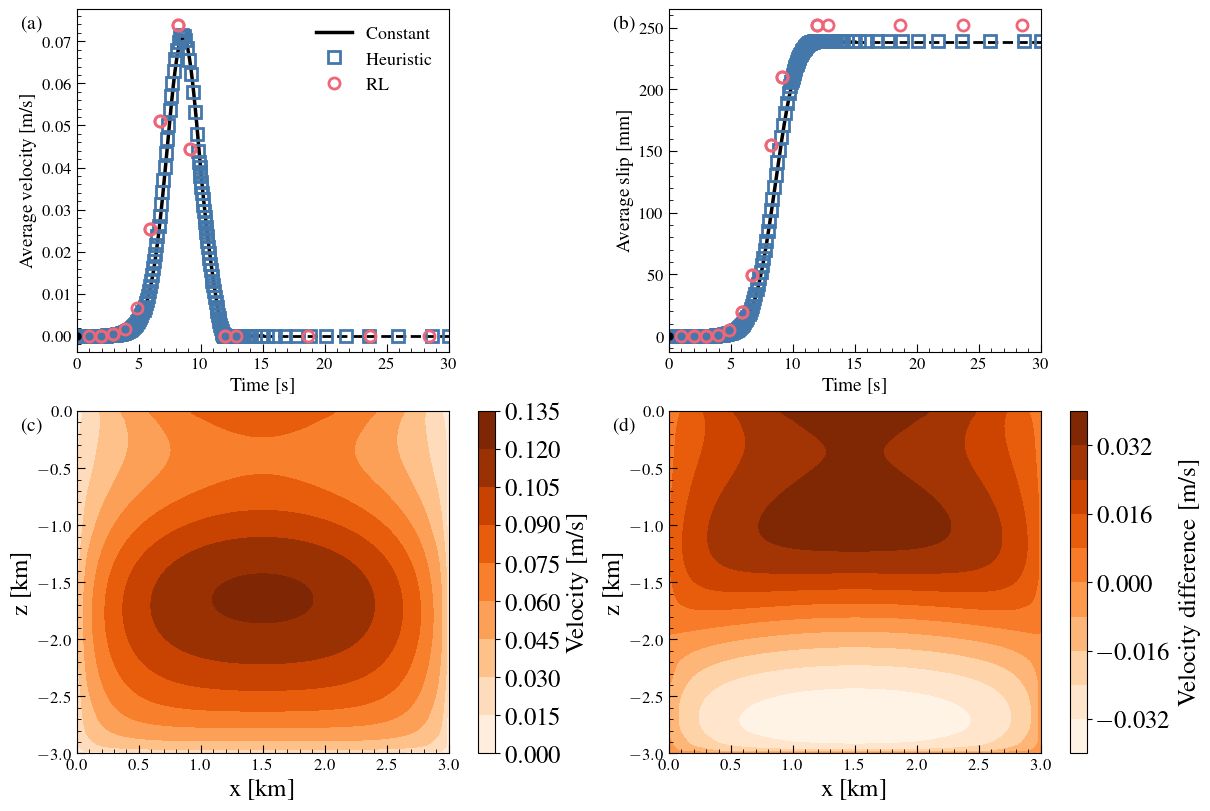

In [115]:
import json
import numpy as np
from pathlib import Path
import scipy.ndimage
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ---------------------------------------------------------------------------
# Load series_alpha2.json (RL + heuristic PI / baseline)
# ---------------------------------------------------------------------------
RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
series_path = RUN_ROOT / "series_alpha2.json"

with open(series_path, "r", encoding="utf-8") as fh:
    series_json = json.load(fh)

# Rebuild numpy arrays, including full fields if present
series_loaded = {}
for name, data in series_json.items():
    series_loaded[name] = {
        "times": np.asarray(data["times"], float),          # code units
        "mean_v": np.asarray(data["mean_v"], float),        # as stored
        "mean_u": np.asarray(data["mean_u"], float),
        "runtime_s": float(data["runtime_s"]),
        "runtime_std": float(data["runtime_std"]),
        "converged": bool(data["converged"]),
        "h_attempts": np.asarray(data["h_attempts"], float),
        "ts_attempts": np.asarray(data["ts_attempts"], float),
        "attempt_accepted": np.asarray(data["attempt_accepted"], bool),
        # full fields (may be empty for baseline)
        "v_field": np.asarray(data.get("v_field", []), float),
        "u_field": np.asarray(data.get("u_field", []), float),
    }

# ---------------------------------------------------------------------------
# Extract heuristic PI (baseline) and RL series
# ---------------------------------------------------------------------------
baseline = series_loaded["adaptive_integrator"]
t_pi_code        = baseline["times"]        # code units
avg_v_heuristic  = baseline["mean_v"]
avg_s_heuristic  = baseline["mean_u"]

# RL policy: first key starting with "TQC"
rl_key_candidates = [k for k in series_loaded.keys() if k.startswith("TQC")]
if not rl_key_candidates:
    raise RuntimeError("No TQC RL series found in series_alpha2.json")
rl_key = rl_key_candidates[0]

rl_series = series_loaded[rl_key]
t_rl_code  = rl_series["times"]            # code units
avg_v_RL   = rl_series["mean_v"]
avg_s_RL   = rl_series["mean_u"]
v_rl_all   = rl_series["v_field"]          # shape (Nt_rl, N)
u_rl_all   = rl_series["u_field"]

if v_rl_all.size == 0:
    raise RuntimeError("RL series has no v_field stored; did you rerun the saver code?")

# ---------------------------------------------------------------------------
# Load constant-stepper results (dimensionless state -> scale to physical)
# ---------------------------------------------------------------------------
results_dir = Path(".")  # or fault.result_dir if you store it there
const_file = results_dir / "constant_stepper_50by50.npz"  # adapt if needed

if not const_file.exists():
    raise FileNotFoundError(f"Constant-stepper file not found: {const_file}")

const = np.load(const_file)
N = fault.N  # from your fault object

ts_const_code = const["ts1"]      # times (code units)
ys_const      = const["ys1"]      # states (Nt_const, n_state)

# layout y = [v, ?, s, ...]; using [:N] and [2N:3N]
v_const_all_dimless = ys_const[:, :N]
s_const_all_dimless = ys_const[:, 2 * N:3 * N]

# Scale to physical units using fault scalings
v_const_all = v_const_all_dimless * fault.Vscale
s_const_all = s_const_all_dimless * fault.Dscale

# Averages for top-row plots
avg_v_constant = np.mean(v_const_all, axis=1)
avg_s_constant = np.mean(s_const_all, axis=1)

# ---------------------------------------------------------------------------
# Time conversion helpers
# ---------------------------------------------------------------------------
def to_seconds(t_code):
    """Convert code time to seconds."""
    return np.asarray(t_code) * fault.Tscale / 1000.0

# Physical times for plotting
t_const_sec = to_seconds(ts_const_code)
t_pi_sec    = to_seconds(t_pi_code)
t_rl_sec    = to_seconds(t_rl_code)

# ---------------------------------------------------------------------------
# Helper: RL peak time (in seconds)
# ---------------------------------------------------------------------------
def find_rl_peak_time(t_rl_sec, avg_v_RL_phys):
    """
    Find index of RL peak average velocity and its time.

    Parameters
    ----------
    t_rl_sec : array (seconds)
    avg_v_RL_phys : array (physical units)

    Returns
    -------
    idx_rl : int
    t_rl_peak : float (seconds)
    """
    t_rl_sec = np.asarray(t_rl_sec)
    avg_v_RL_phys = np.asarray(avg_v_RL_phys)
    idx_rl = int(np.argmax(avg_v_RL_phys))
    t_rl_peak = float(t_rl_sec[idx_rl])
    print(f"RL peak at idx={idx_rl}, t={t_rl_peak:.4f}s")
    return idx_rl, t_rl_peak

# ---------------------------------------------------------------------------
# Style: Tol "bright" palette + markers
# ---------------------------------------------------------------------------
COLORS = {
    "constant":  "#000000",  # black
    "heuristic": "#4477AA",  # strong blue
    "rl":        "#EE6677",  # vermillion/red
}
MARKERS = {
    "heuristic": "s",  # square
    "rl":        "o",  # circle
}

# ---------------------------------------------------------------------------
# Plotter for 2×2 figure
# ---------------------------------------------------------------------------
class MyPlotter:
    def __init__(self, Nx, Nz, xlength, depth_ini, zdepth):
        self.Nx = Nx
        self.Nz = Nz
        self.N  = Nx * Nz
        self.xlength   = xlength    # km
        self.depth_ini = depth_ini  # km
        self.zdepth    = zdepth     # km
        self.pts_x = None
        self.pts_z = None

    # ---------- meshing helpers ----------
    def nop(self, i, j):
        return i + j * self.Nx

    def mesh_from_field(self, field_1d, smooth=3.0):
        field_1d = np.asarray(field_1d)
        if field_1d.size != self.N:
            raise ValueError(
                f"Field length {field_1d.size} does not match Nx*Nz={self.N}."
            )

        z = np.array(
            [[field_1d[self.nop(i, j)] for i in range(self.Nx)]
             for j in range(self.Nz)]
        )

        if smooth is not None and smooth > 1.0:
            z = scipy.ndimage.zoom(z, smooth)

        x, y = np.meshgrid(
            np.linspace(0.0, self.xlength, z.shape[1], endpoint=True),
            np.linspace(-self.depth_ini,
                        -self.zdepth - self.depth_ini,
                        z.shape[0],
                        endpoint=True),
        )
        return x, y, z

    def _extend_v(self, z, vmin=None, vmax=None):
        extend = "neither"
        if vmax is None:
            vmax = z.max()
        if vmin is None:
            vmin = z.min()
        if vmax < z.max():
            extend = "max"
        if vmin > z.min():
            extend = "min"
        if vmax < z.max() and vmin > z.min():
            extend = "both"
        if vmin == vmax:
            vmax = vmin + 1.0
        return extend, vmin, vmax

    def plot_contour(self, ax, field_1d,
                     vmin=None, vmax=None,
                     cmap="Oranges",
                     clabel="Velocity [m/s]",
                     smooth=3.0,
                     show_discretization=False):
        x, y, z = self.mesh_from_field(field_1d, smooth=smooth)
        extend, vmin, vmax = self._extend_v(z, vmin, vmax)
        cf = ax.contourf(
            x, y, z, levels=10,
            cmap=plt.get_cmap(cmap),
            vmin=vmin, vmax=vmax, extend=extend,
        )
        cb = plt.colorbar(cf, ax=ax)
        cb.set_label(clabel)
        if show_discretization and (self.pts_x is not None):
            ax.plot(self.pts_x, -self.pts_z, "+", color="black", alpha=0.4)
        ax.set_xlabel("x [km]")
        ax.set_ylabel("z [km]")

    # ---------- main 2×2 plot ----------
    def plot_2x2(self,
                 t_const, avg_v_constant, avg_s_constant,
                 t_pi, avg_v_heuristic, avg_s_heuristic,
                 t_rl, avg_v_RL, avg_s_RL,
                 v_const_all, v_rl_all):
        """
        t_* arrays are in SECONDS.
        v_const_all, v_rl_all are (Nt, N) full velocity fields in physical units.
        """

        t_const = np.asarray(t_const)
        t_rl    = np.asarray(t_rl)
        avg_v_RL = np.asarray(avg_v_RL)

        # 1) RL peak time and index (using physical averages)
        idx_rl, t_rl_peak = find_rl_peak_time(t_rl, avg_v_RL)

        # 2) Interpolate constant velocity field in time to t_rl_peak
        if np.any(np.diff(t_const) <= 0.0):
            raise ValueError("t_const must be strictly increasing for interp1d.")

        interp_fun = interp1d(
            t_const, v_const_all, axis=0,
            kind="linear", bounds_error=False,
            fill_value=(v_const_all[0, :], v_const_all[-1, :]),
        )
        v_const_interp = np.asarray(interp_fun(t_rl_peak)).ravel()

        # RL snapshot at its peak time
        v_rl_snap = v_rl_all[idx_rl, :].ravel()

        # For info: what is the nearest constant-step time to this RL time?
        idx_const_near = int(np.argmin(np.abs(t_const - t_rl_peak)))
        dt_near = float(abs(t_const[idx_const_near] - t_rl_peak))
        print(
            f"Nearest constant time to RL peak: "
            f"t_const={t_const[idx_const_near]:.4f}s, Δt={dt_near:.2e}s"
        )

        # 3) Difference field (no division → no blow-up near zero)
        diff_field = v_rl_snap - v_const_interp

        # axis/time settings
        t_plot_end = 30.0
        t_const_end = float(t_const[-1])
        v_const_end = float(avg_v_constant[-1])
        s_const_end = float(avg_s_constant[-1])

        label_fs = 14
        tick_fs  = 12
        panel_fs = 14

        fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

        for ax in axs.flat:
            ax.minorticks_on()
            ax.tick_params(axis='both', which='both', direction='in',
                           labelsize=tick_fs)
            ax.tick_params(axis='both', which='major', length=6)
            ax.tick_params(axis='both', which='minor', length=3)
            ax.grid(False)

        # ---- (a) Average velocity ----
        ax_a = axs[0, 0]
        ax_a.plot(t_const, avg_v_constant,
                  color=COLORS["constant"],
                  linewidth=2.5,
                  label="Constant")
        if t_const_end < t_plot_end:
            ax_a.plot([t_const_end, t_plot_end],
                      [v_const_end, v_const_end],
                      linestyle="--",
                      linewidth=2.0,
                      color=COLORS["constant"])

        ax_a.plot(t_pi, avg_v_heuristic,
                  linestyle='None',
                  marker=MARKERS["heuristic"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["heuristic"],
                  markeredgewidth=2.0,
                  label="Heuristic")
        ax_a.plot(t_rl, avg_v_RL,
                  linestyle='None',
                  marker=MARKERS["rl"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["rl"],
                  markeredgewidth=2.0,
                  label="RL")

        ax_a.plot(0.0, 0.0, marker='o', markersize=5,
                  color='k', zorder=10)

        ax_a.set_ylabel("Average velocity [m/s]", fontsize=label_fs)
        ax_a.set_xlabel("Time [s]", fontsize=label_fs)
        ax_a.set_xlim(0, t_plot_end)
        ax_a.margins(x=0.02, y=0.05)
        ax_a.legend(loc="upper right", frameon=False, fontsize=label_fs-1)
        ax_a.text(-0.15, 0.98, "(a)", transform=ax_a.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        # ---- (b) Average slip ----
        ax_b = axs[0, 1]
        ax_b.plot(t_const, avg_s_constant,
                  color=COLORS["constant"],
                  linewidth=2.5,
                  label="Constant")
        if t_const_end < t_plot_end:
            ax_b.plot([t_const_end, t_plot_end],
                      [s_const_end, s_const_end],
                      linestyle="--",
                      linewidth=2.0,
                      color=COLORS["constant"])

        ax_b.plot(t_pi, avg_s_heuristic,
                  linestyle='None',
                  marker=MARKERS["heuristic"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["heuristic"],
                  markeredgewidth=2.0,
                  label="Heuristic")
        ax_b.plot(t_rl, avg_s_RL,
                  linestyle='None',
                  marker=MARKERS["rl"],
                  markersize=8,
                  markerfacecolor='none',
                  markeredgecolor=COLORS["rl"],
                  markeredgewidth=2.0,
                  label="RL")

        ax_b.plot(0.0, 0.0, marker='o', markersize=5,
                  color='k', zorder=10)

        ax_b.set_ylabel("Average slip [mm]", fontsize=label_fs)
        ax_b.set_xlabel("Time [s]", fontsize=label_fs)
        ax_b.set_xlim(0, t_plot_end)
        ax_b.margins(x=0.02, y=0.05)
        ax_b.text(-0.15, 0.98, "(b)", transform=ax_b.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        # ---- (c) RL velocity field at RL peak ----
        ax_c = axs[1, 0]
        self.plot_contour(
            ax_c,
            v_rl_snap,
            cmap="Oranges",
            clabel="Velocity [m/s]",
        )
        ax_c.text(-0.15, 0.98, "(c)", transform=ax_c.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        # ---- (d) Difference field: RL − Constant at same time ----
        ax_d = axs[1, 1]
        self.plot_contour(
            ax_d,
            diff_field,
            cmap="Oranges",
            clabel="Velocity difference [m/s]",
        )
        ax_d.text(-0.15, 0.98, "(d)", transform=ax_d.transAxes,
                  fontsize=panel_fs, va="top", ha="left")

        fig.savefig("figure7.pdf", dpi=300, bbox_inches="tight")
        plt.show()

# ---------------------------------------------------------------------------
# Instantiate plotter and make the figure
# ---------------------------------------------------------------------------
plotter = MyPlotter(
    Nx=50,          # adapt to your mesh
    Nz=50,
    xlength=3.0,   # km
    depth_ini=0.0, # km
    zdepth=3.0,    # km
)

plotter.plot_2x2(
    t_const=t_const_sec,
    avg_v_constant=avg_v_constant,
    avg_s_constant=avg_s_constant,
    t_pi=t_pi_sec,
    avg_v_heuristic=avg_v_heuristic * fault.Vscale,
    avg_s_heuristic=avg_s_heuristic * fault.Dscale - np.mean(u0) * fault.Dscale,
    t_rl=t_rl_sec,
    avg_v_RL=avg_v_RL * fault.Vscale,
    avg_s_RL=avg_s_RL * fault.Dscale - np.mean(u0) * fault.Dscale,
    v_const_all=v_const_all,
    v_rl_all=v_rl_all * fault.Vscale,
)


In [62]:
print(t_rl)

[ 0.          1.14895114  2.29620814  2.29620814  3.40927428  3.40927428
  4.5233313   5.63894866  6.82485847  6.82485847  7.72140983  7.72140983
  9.46300576  9.46300576 10.51293056 10.51293056 13.79568972 20.47548683
 26.31782593 31.80654592 37.12241244]


In [64]:
import numpy as np

def nearest_index_at_time(t_code, Tscale, t_target_sec):
    """
    Return the index i such that the physical time t_code[i] * Tscale
    is closest to t_target_sec.

    Parameters
    ----------
    t_code : 1D array-like
        Time grid in *code units*.
    Tscale : float
        Scale factor from code time to seconds (your fault.Tscale).
    t_target_sec : float
        Target time in seconds.

    Returns
    -------
    idx : int
        Index of t_code closest to t_target_sec in physical units.
    """
    t_phys = np.asarray(t_code) #* Tscale  # or *Tscale/1000, if that's your convention
    idx = int(np.argmin(np.abs(t_phys - t_target_sec)))
    return idx

In [24]:
def nearest_indices_rl_to_constant(ts_const_code, ts_rl_code, Tscale):
    """
    For each constant-step time, find the index of the closest RL time (in physical units).

    Parameters
    ----------
    ts_const_code : 1D array-like
        Constant-stepper times in code units.
    ts_rl_code : 1D array-like
        RL times in code units.
    Tscale : float
        Scale factor from code time to seconds (use the same as everywhere else).

    Returns
    -------
    idx_rl_for_const : 1D numpy array of int
        For each i in ts_const_code, idx_rl_for_const[i] is the index j in ts_rl_code
        such that |t_rl_phys[j] - t_const_phys[i]| is minimal.
    """
    ts_const_phys = np.asarray(ts_const_code) #* Tscale / 1000.0
    ts_rl_phys    = np.asarray(ts_rl_code)    #* Tscale / 1000.0

    idx_rl_for_const = np.empty_like(ts_const_phys, dtype=int)
    for i, t_c in enumerate(ts_const_phys):
        idx_rl_for_const[i] = int(np.argmin(np.abs(ts_rl_phys - t_c)))

    return idx_rl_for_const

In [25]:

idx_rl_for_const = nearest_indices_rl_to_constant(t_const, t_rl, fault.Tscale)


In [70]:

class MyPlotter:
    def __init__(self, N, Nx, Nz, Vscale, Dscale, Pscale, Tscale,
                 xlength, depth_ini, zdepth):
        self.N = N
        self.Nx = Nx
        self.Nz = Nz
        self.Vscale = Vscale
        self.Dscale = Dscale
        self.Pscale = Pscale
        self.Tscale = Tscale
        self.xlength = xlength
        self.depth_ini = depth_ini
        self.zdepth = zdepth

        # optional: store physical node coords if you have them
        self.pts_x = None
        self.pts_z = None

    # ---------- scaling & meshing helpers ----------
    def scale_data(self, xxs):
        # xxs: (nt, n_state)
        vs = xxs[:, :self.N] * self.Vscale
        sr = xxs[:, self.N:2*self.N] * self.Vscale
        ss = xxs[:, 2*self.N:3*self.N] * self.Dscale
        ps = xxs[:, 5*self.N:6*self.N] * self.Pscale
        return vs, sr, ss, ps

    def nop(self, i, j):
        return i + j * self.Nx

    def mesh(self, array, incr, smooth=3.0):
        incr = int(incr)
        z = np.array([[array[incr, self.nop(i, j)]
                       for i in range(self.Nx)]
                      for j in range(self.Nz)])
        z = scipy.ndimage.zoom(z, smooth)
        x, y = np.meshgrid(
            np.linspace(0, self.xlength, z.shape[1], endpoint=True),
            np.linspace(-self.depth_ini,
                        -self.zdepth - self.depth_ini,
                        z.shape[0],
                        endpoint=True),
        )
        return x, y, z

    def extend_v(self, z, vmin=None, vmax=None):
        extend = "neither"
        if vmax is None:
            vmax = z.max()
        if vmin is None:
            vmin = z.min()
        if vmax < z.max():
            extend = "max"
        if vmin > z.min():
            extend = "min"
        if vmax < z.max() and vmin > z.min():
            extend = "both"
        if vmin == vmax:
            vmax = vmin + 1.0
        return extend, vmin, vmax

    def plot_contour(self, ax, array, incr,
                     vmin=None, vmax=None,
                     cmap="Blues",
                     clabel="Velocity [m/s]",
                     show_discretization=False):
        x, y, z = self.mesh(array, incr)
        extend, vmin, vmax = self.extend_v(z, vmin, vmax)
        cf = ax.contourf(
            x, y, z, levels=10,
            cmap=plt.get_cmap(cmap),
            vmin=vmin, vmax=vmax, extend=extend,
        )
        cb = plt.colorbar(cf, ax=ax)
        cb.set_label(clabel)
        if show_discretization and (self.pts_x is not None):
            ax.plot(self.pts_x, -self.pts_z, "+", color="black", alpha=0.4)
        ax.set_xlabel("x [km]")
        ax.set_ylabel("z [km]")


In [ ]:
import scipy.ndimage
import matplotlib.pyplot as plt

    # ---------- main 2×2 plot ----------
    def plot_2x2(self,
                 xxs, tts,
                 ts1_loaded, ys1_loaded,
                 ts2_loaded, ys2_loaded,
                 avg_v_constant, avg_v_heuristic, avg_v_RL,
                 avg_s_constant, avg_s_heuristic, avg_s_RL,
                 target_time=8.0):
        """
        xxs, tts : RL trajectory & times (code units)
        ts1_loaded, ys1_loaded : constant-stepper times & states
        ts2_loaded, ys2_loaded : PI / heuristic times & states
        avg_v_* , avg_s_* : pre-computed averages (already scaled)
        target_time : snapshot time in seconds
        """

        # scale full fields for constant-stepper and RL
        v_const, _, _, _ = self.scale_data(ys1_loaded)     # (Nt_const, N)
        v_rl,    _, _, _ = self.scale_data(xxs)            # (Nt_rl, N)

        # indices of snapshot closest to target_time in each run
        idx_const = nearest_index_at_time(ts1_loaded, self.Tscale, target_time)
        idx_rl    = nearest_index_at_time(tts,         self.Tscale, target_time)

        # physical time arrays (for plotting on x axis)
        t_const_phys = ts1_loaded * self.Tscale / 1000.0
        t_pi_phys    = ts2_loaded * self.Tscale / 1000.0
        t_rl_phys    = tts         * self.Tscale / 1000.0

        # Create 2×2 subplot grid
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))

        # ---- (a) Average velocity ----
        axs[0, 0].plot(t_const_phys, avg_v_constant, color="black", label="Constant")
        axs[0, 0].plot(t_pi_phys,    avg_v_heuristic, "-s", color="blue", label="Heuristic")
        axs[0, 0].plot(t_rl_phys,    avg_v_RL,        "-o", color="red",  label="RL")
        axs[0, 0].set_ylabel("Average velocity [m/s]")
        axs[0, 0].set_xlabel("Time [s]")
        axs[0, 0].set_xlim(0, 30)
        axs[0, 0].grid()
        axs[0, 0].legend()
        axs[0, 0].text(
            -0.15, 1.05, "(a)",
            transform=axs[0, 0].transAxes,
            fontsize=12,
            va="top",
        )

        # ---- (b) Average slip ----
        axs[0, 1].plot(t_const_phys, avg_s_constant, color="black", label="Constant")
        axs[0, 1].plot(t_pi_phys,    avg_s_heuristic, "-s", color="blue", label="Heuristic")
        axs[0, 1].plot(t_rl_phys,    avg_s_RL,        "-o", color="red",  label="RL")
        axs[0, 1].set_ylabel("Average slip [mm]")
        axs[0, 1].set_xlabel("Time [s]")
        axs[0, 1].set_xlim(0, 30)
        axs[0, 1].grid()
        axs[0, 1].legend()
        axs[0, 1].text(
            -0.15, 1.05, "(b)",
            transform=axs[0, 1].transAxes,
            fontsize=12,
            va="top",
        )

        # ---- (c) Constant-stepper field at target_time ----
        self.plot_contour(
            axs[1, 0],
            v_const,                 # full time × dof array
            incr=idx_const,          # snapshot index
            cmap="Oranges",
            clabel="Velocity [m/s]",
        )
        axs[1, 0].text(
            -0.15, 1.05, "(c)",
            transform=axs[1, 0].transAxes,
            fontsize=12,
            va="top",
        )

        # ---- (d) Relative error field RL vs constant at target_time ----
        v_const_snap = v_const[idx_const, :]   # shape (N,)
        v_rl_snap    = v_rl[idx_rl, :]         # shape (N,)

        # relative error in %, same ordering of DOFs
        rel_err = (v_rl_snap - v_const_snap) / v_const_snap * 100.0

        # plot_contour expects (Nt, N), so wrap in [1, N]
        rel_err_array = rel_err.reshape(1, -1)
        self.plot_contour(
            axs[1, 1],
            rel_err_array,
            incr=0,
            cmap="Oranges",          # or e.g. "RdBu_r" if you want sign
            clabel="Relative error [%]",
        )
        axs[1, 1].text(
            -0.15, 1.05, "(d)",
            transform=axs[1, 1].transAxes,
            fontsize=12,
            va="top",
        )

        plt.tight_layout()
        fig.savefig("plot_2x2.png", dpi=300, bbox_inches="tight")
        plt.show()


In [28]:
plotter = MyPlotter(
    N=fault.N,
    Nx=50,
    Nz=50,
    Vscale=fault.Vscale,
    Dscale=fault.Dscale,
    Pscale=fault.Pscale,
    Tscale=fault.Tscale,
    xlength=3,
    depth_ini=0.0,
    zdepth=3,
)

target_time = 8.0  # seconds

plotter.plot_2x2(
    xxs=xxs,
    tts=tts,
    ts1_loaded=ts1_loaded,
    ys1_loaded=ys1_loaded,
    ts2_loaded=ts2_loaded,
    ys2_loaded=ys2_loaded,
    avg_v_constant=avg_v_constant,
    avg_v_heuristic=avg_v_heuristic,
    avg_v_RL=avg_v_RL,
    avg_s_constant=avg_s_constant,
    avg_s_heuristic=avg_s_heuristic,
    avg_s_RL=avg_s_RL,
    target_time=target_time,
)


NameError: name 'xxs' is not defined

In [ ]:
# import numpy as np
# import os
# from pathlib import Path

# # 1) Path to constant-stepper results (adapt if you changed the name)
# results_dir = Path("RL_Adaption/2D_FAULT")  # or fault.result_dir if you store it
# const_file = results_dir / "constant_stepper_100by100.npz"  # example name

# if not const_file.exists():
#     raise FileNotFoundError(f"Constant-stepper file not found: {const_file}")

# # 2) Load constant-stepper data
# const = np.load(const_file)
# ts1_loaded = const["t"]   # constant-stepper times (code units)
# ys1_loaded = const["y"]   # constant-stepper states (shape (Nt_const, n_state))

# print("Constant-stepper shapes:", ts1_loaded.shape, ys1_loaded.shape)

# # 3) RL trajectory from your existing run
# #    (assumes you already ran the RL eval and have these in scope)
# #    tts: RL times (code units)
# #    xxs: RL states (shape (Nt_rl, n_state))

# # 4) Use fault scales that were built in earlier cells
# Tscale = fault.Tscale  # used for conversion to seconds
# Vscale = fault.Vscale
# Dscale = fault.Dscale
# Pscale = fault.Pscale

# # 5) Example: build the MyPlotter and call plot_2x2
# plotter = MyPlotter(
#     N=fault.N,
#     Nx=fault.Nx,
#     Nz=fault.Nz,
#     Vscale=Vscale,
#     Dscale=Dscale,
#     Pscale=Pscale,
#     Tscale=Tscale,
#     xlength=fault.xlength,
#     depth_ini=fault.depth_ini,
#     zdepth=fault.zdepth,
# )

# # you should already have: avg_v_constant, avg_v_heuristic, avg_v_RL,
# #                          avg_s_constant, avg_s_heuristic, avg_s_RL
# plotter.plot_2x2(
#     xxs, tts,
#     ts1_loaded, ys1_loaded,    # constant-stepper
#     ts2_loaded, ys2_loaded,    # PI/heuristic (loaded similarly)
#     avg_v_constant, avg_v_heuristic, avg_v_RL,
#     avg_s_constant, avg_s_heuristic, avg_s_RL,
#     target_time=8.0,
# )